# Common import 

In [1]:
import os
import re
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn
from scipy.stats import ttest_ind
rcParams["font.family"] = "arial"

with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.BaseLoader)
    
samples = config["samples"]

# 2021-03-22 Summary

In [191]:
def str2int(s):
    return int(s.replace(",", ""))

def get_raw_reads(sample):
    path = "results/mapping/mapped.1st/%s/Log.final.out" % sample
    with open(path) as f:
        for line in f:
            line = line.strip("\n")
            if "Number of input reads" in line:
                return str2int(line.split()[-1])
            
def get_unique_mapped(sample):
    path = "results/mapping/mapped.1st/%s/Log.final.out" % sample
    with open(path) as f:
        for line in f:
            line = line.strip("\n")
            if "Uniquely mapped reads number" in line:
                return str2int(line.split()[-1]) 
            
def get_multi_mapped(sample):
    path = "results/mapping/mapped.1st/%s/Log.final.out" % sample
    with open(path) as f:
        for line in f:
            line = line.strip("\n")
            if "Number of reads mapped to multiple loci" in line:
                return str2int(line.split()[-1]) 
            
def get_unique_mapped_2(sample):
    path = "results/mapping/mapped.2nd/%s/Log.final.out" % sample
    with open(path) as f:
        for line in f:
            line = line.strip("\n")
            if "Uniquely mapped reads number" in line:
                return str2int(line.split()[-1]) 
            
def get_multi_mapped_2(sample):
    path = "results/mapping/mapped.2nd/%s/Log.final.out" % sample
    with open(path) as f:
        for line in f:
            line = line.strip("\n")
            if "Number of reads mapped to multiple loci" in line:
                return str2int(line.split()[-1]) 
            
def get_filtered_read(sample):
    path = "results/mapping/filtered/%s.stats" % sample
    with open(path) as f:
        for line in f:
            line = line.strip("\n")
            if "Read 1:" in line:
                return str2int(line.split()[-1]) 

def get_assigned_read(sample):
    path = "results/expression/featureCount/%s.txt.summary" % sample
    with open(path) as f:
        for line in f:
            line = line.strip("\n")
            if "Assigned" in line:
                return str2int(line.split()[-1])

def get_no_feature_read(sample):
    path = "results/expression/featureCount/%s.txt.summary" % sample
    with open(path) as f:
        for line in f:
            line = line.strip("\n")
            if "Unassigned_NoFeatures" in line:
                return str2int(line.split()[-1])
            
def get_ambiguity_read(sample):
    path = "results/expression/featureCount/%s.txt.summary" % sample
    with open(path) as f:
        for line in f:
            line = line.strip("\n")
            if "Unassigned_Ambiguity" in line:
                return str2int(line.split()[-1])
            
            
dat = pd.DataFrame(index=pd.Index(samples, name="Sample"))
dat["RawRead"] = list(map(get_raw_reads, samples))
dat["UniqueMapped"] = list(map(get_unique_mapped, samples))
dat["UniqueMappedRatio"] = dat["UniqueMapped"] / dat["RawRead"]
dat["MultiMapped"] = list(map(get_multi_mapped, samples))
dat["MultiMappedRatio"] = dat["MultiMapped"] / dat["RawRead"]
dat["UniqueMapped2"] = list(map(get_unique_mapped_2, samples))
dat["UniqueMappedRatio2"] = dat["UniqueMapped2"] / dat["RawRead"]
dat["MultiMapped2"] = list(map(get_multi_mapped_2, samples))
dat["MultiMappedRatio2"] = dat["MultiMapped2"] / dat["RawRead"]
dat["FilteredRead"] = list(map(get_filtered_read, samples))
dat["FilteredRatio"] = dat["FilteredRead"] / dat["RawRead"]
dat["FeatureAssigned"] = list(map(get_assigned_read, samples))
dat["FeatureAssignedRatio"] = dat["FeatureAssigned"] / dat["FilteredRead"]
dat["FeatureNoFeature"] = list(map(get_no_feature_read, samples))
dat["FeatureNoFeatureRatio"] = dat["FeatureNoFeature"] / dat["FilteredRead"]
dat["FeatureAmbiguity"] = list(map(get_ambiguity_read, samples))
dat["FeatureAmbiguityRatio"] = dat["FeatureAmbiguity"] / dat["FilteredRead"]
dat.to_excel("summary.xlsx")

# 2021-03-23 Plot summary

In [5]:
dat = pd.read_excel("summary.xlsx", index_col=0)

In [85]:
# plot the raw read scatter

ys = dat["RawRead"].values / 1e6
xs = np.random.rand(len(ys)) * 0.5 + 0.25

batches = []
for sample in samples:
    path1 = "data/datasets/%s_R1.fastq.gz" % sample
    path2 = os.readlink(path1)
    if "F20FTSCCKF0955_FISgaaE" in path2:
        batches.append(0)
    elif "F20FTSCCKF1558_YUocvE" in path2:
        batches.append(1)
    else:
        batches.append(2)

xs1 = []
ys1 = []
xs2 = []
ys2 = []
xs3 = []
ys3 = []
for x, y, b in zip(xs, ys, batches):
    if b == 0:
        xs1.append(x)
        ys1.append(y)
    elif b == 1:
        xs2.append(x)
        ys2.append(y)
    else:
        xs3.append(x)
        ys3.append(y)
        
plt.figure(figsize=(4, 4))
plt.scatter(xs1, ys1, color="red", marker="s", label="Batch 1 (%d)" % len(xs1))
plt.scatter(xs2, ys2, color="blue", marker="v", label="Batch 2 (%d)" % len(xs2))
plt.scatter(xs3, ys3, color="green", marker="o", label="Batch 3 (%d)" % len(xs3))
plt.xlim(0, 1)
plt.xticks([])
plt.ylim(40, 80)
plt.yticks([40, 50, 60, 70, 80])
plt.ylabel("Library size (M)")
plt.legend(frameon=True)

plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/raw_read.scatter.png", dpi=300)
plt.close()

In [137]:
# plot ratio
tmp = dat[["UniqueMappedRatio2", "MultiMappedRatio2"]] * 100
ys = tmp.mean()
ye = tmp.std()
xs = [0, 1]
xticks = ["Unique", "Multiple"]
plt.figure(figsize=(2, 3))
plt.bar(xs, ys, yerr=ye, width=0.6, color="dodgerblue", lw=1, 
        edgecolor="black", error_kw={"capsize": 4, "linewidth": 1, "capthick": 1})
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# plt.gca().spines["bottom"].set_visible(False)

plt.xlim(-0.5, 1.5)
plt.xlabel("Mapping")
plt.xticks(xs, xticks)
plt.ylim(0, 100)
plt.ylabel("Ratio (%)")
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/mapping.ratio.bar.png", dpi=300)
plt.close()

In [25]:
bs1 = np.zeros(len(dat))
xs1 = dat["FeatureAssignedRatio"].values
bs2 = xs1 + bs1
xs2 = dat["FeatureNoFeatureRatio"].values
bs3 = xs2 + bs2
xs3 = dat["FeatureAmbiguityRatio"].values
ys = np.arange(len(dat))[::-1]

plt.figure(figsize=(6, 4))
plt.barh(ys, xs1, left=bs1, height=1, label="Assigned")
plt.barh(ys, xs2, left=bs2, height=1, label="No feature")
plt.barh(ys, xs3, left=bs3, height=1, label="Ambiguity")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlim(0, 1)
plt.xlabel("Proportion")
plt.ylim(min(ys) - 0.5, max(ys) + 0.5)
# plt.yticks(ys, dat.index)
plt.yticks([])
plt.grid(ls="--", lw=1, color="lightgray")
plt.legend(loc="upper left", bbox_to_anchor=[1, 1])
plt.tight_layout(rect=(0, 0, 1, 1))
if False:
    plt.show()
else:
    plt.savefig("figures/feature.distribution.png", dpi=300)
plt.close()

NameError: name 'np' is not defined

# Heatmap of expression (StringTie)

In [29]:
samples1 = [
     'Ju_Br_Mi_1',
     'Ju_Br_Mi_2',
     'Ad_Br_Ma_1',
     'Ad_Br_Ma_2',
     'Ad_Br_Fe_1',
     'Ad_Br_Fe_2',
     'Ju_Ey_Mi_1',
     'Ju_Ey_Mi_2',
     'Ad_Ey_Ma_1',
     'Ad_Ey_Ma_2',
     'Ad_Ey_Fe_1',
     'Ad_Ey_Fe_2',
     'Ju_Gi_Mi_1',
     'Ju_Gi_Mi_2',
     'Ad_Gi_Ma_1',
     'Ad_Gi_Ma_2',
     'Ad_Gi_Fe_1',
     'Ad_Gi_Fe_2',
     'Ju_Go_Mi_1',
     'Ju_Go_Mi_2',
     'Ad_Go_Ma_1',
     'Ad_Go_Ma_2',
     'Ad_Go_Fe_1',
     'Ad_Go_Fe_2',
     'Ju_He_Mi_1',
     'Ju_He_Mi_2',
     'Ad_He_Ma_1',
     'Ad_He_Ma_2',
     'Ad_He_Fe_1',
     'Ad_He_Fe_2',
     'Ju_Ki_Mi_1',
     'Ju_Ki_Mi_2',
     'Ad_Ki_Ma_1',
     'Ad_Ki_Ma_2',
     'Ad_Ki_Fe_1',
     'Ad_Ki_Fe_2',
     'Ju_Li_Mi_1',
     'Ju_Li_Mi_2',
     'Ad_Li_Ma_1',
     'Ad_Li_Ma_2',
     'Ad_Li_Fe_1',
     'Ad_Li_Fe_2',
     'Ju_Mu_Mi_1',
     'Ju_Mu_Mi_2',
     'Ad_Mu_Ma_1',
     'Ad_Mu_Ma_2',
     'Ad_Mu_Fe_1',
     'Ad_Mu_Fe_2',
     'Ju_In_Mi_1',
     'Ju_In_Mi_2',
     'Ad_In_Ma_1',
     'Ad_In_Ma_2',
     'Ad_In_Fe_1',
     'Ad_In_Fe_2',
     'Ad_Pi_Ma_1',
     'Ad_Pi_Ma_2',
     'Ad_Pi_Fe_1',
     'Ad_Pi_Fe_2',
     'Ad_Sp_Ma_1',
     'Ad_Sp_Ma_2',
     'Ad_Sp_Fe_1',
     'Ad_Sp_Fe_2',
     'Ad_St_Ma_1',
     'Ad_St_Ma_2',
     'Ad_St_Fe_1',
     'Ad_St_Fe_2'
]
print(len(samples1))

66


In [30]:
array = []
for sample in samples1:
    path = "results/stringtie.0323/round2/%s/gene_abund.tab" % sample
    dat = pd.read_csv(path, sep="\t", index_col=0)
    s = dat["FPKM"]
    s.name = sample
    array.append(s)
fpkms = pd.concat(array, axis=1)
fpkms.head()

,Ju_Br_Mi_1,Ju_Br_Mi_2,Ad_Br_Ma_1,Ad_Br_Ma_2,Ad_Br_Fe_1,Ad_Br_Fe_2,Ju_Ey_Mi_1,Ju_Ey_Mi_2,Ad_Ey_Ma_1,Ad_Ey_Ma_2,...,Ad_Pi_Fe_1,Ad_Pi_Fe_2,Ad_Sp_Ma_1,Ad_Sp_Ma_2,Ad_Sp_Fe_1,Ad_Sp_Fe_2,Ad_St_Ma_1,Ad_St_Ma_2,Ad_St_Fe_1,Ad_St_Fe_2
merge.132,6.250750,9.952289,0.425527,2.178473,1.980333,11.456005,1.128706,1.070813,2.378695,4.986327,...,1.398841,1.163770,0.083507,0.121489,0.049684,0.090336,0.333997,0.372391,0.273018,0.336852
merge.27,2.462344,2.459624,3.118614,2.959004,2.189586,2.400510,2.012923,4.358818,2.631645,1.463292,...,3.010992,3.327859,7.930336,7.908926,5.993654,6.677077,1.332807,1.304143,1.210734,1.948782
merge.28,7.779694,8.503828,6.387408,5.612966,4.011495,8.162672,0.619214,0.518966,2.744093,3.684508,...,3.042011,2.305303,1.108744,1.207330,1.353379,1.045796,0.398632,0.227957,0.192587,0.219943
merge.29,1.832471,2.077259,2.289999,1.800353,2.888757,1.492386,1.139957,0.729332,3.384535,2.700561,...,1.813596,1.543015,1.693010,1.892394,1.959626,1.886005,0.779946,0.509231,0.418697,0.511023
merge.30,21.205828,22.295984,43.150219,37.139595,26.654490,9.919307,0.689013,0.059205,1.208765,2.720124,...,13.425976,10.397477,0.392340,0.262161,0.377346,0.323755,0.020150,0.033713,0.000000,0.042457


In [31]:
corr = fpkms[fpkms.max(axis=1) >= 1].corr()
corr.head()

,Ju_Br_Mi_1,Ju_Br_Mi_2,Ad_Br_Ma_1,Ad_Br_Ma_2,Ad_Br_Fe_1,Ad_Br_Fe_2,Ju_Ey_Mi_1,Ju_Ey_Mi_2,Ad_Ey_Ma_1,Ad_Ey_Ma_2,...,Ad_Pi_Fe_1,Ad_Pi_Fe_2,Ad_Sp_Ma_1,Ad_Sp_Ma_2,Ad_Sp_Fe_1,Ad_Sp_Fe_2,Ad_St_Ma_1,Ad_St_Ma_2,Ad_St_Fe_1,Ad_St_Fe_2
Ju_Br_Mi_1,1.000000,0.971232,0.813792,0.808752,0.890324,0.861206,0.049963,0.092129,0.316121,0.329073,...,0.105336,0.090632,0.312996,0.319924,0.242094,0.190450,0.044689,0.029444,0.024248,0.027304
Ju_Br_Mi_2,0.971232,1.000000,0.780888,0.893196,0.839985,0.809774,0.050012,0.093459,0.311078,0.306885,...,0.087652,0.070287,0.316770,0.322819,0.244780,0.192342,0.043442,0.028900,0.023661,0.026871
Ad_Br_Ma_1,0.813792,0.780888,1.000000,0.617963,0.921676,0.900523,0.060704,0.110996,0.356826,0.337308,...,0.108796,0.085777,0.366504,0.369034,0.261241,0.189943,0.048851,0.034331,0.028068,0.032692
Ad_Br_Ma_2,0.808752,0.893196,0.617963,1.000000,0.654909,0.540755,0.039212,0.074532,0.222412,0.201060,...,0.072676,0.057211,0.254160,0.256899,0.188539,0.141292,0.029921,0.020598,0.017235,0.020063
Ad_Br_Fe_1,0.890324,0.839985,0.921676,0.654909,1.000000,0.893040,0.058705,0.109199,0.349560,0.334335,...,0.107890,0.086027,0.370133,0.373636,0.275510,0.205893,0.048001,0.032225,0.026957,0.030641


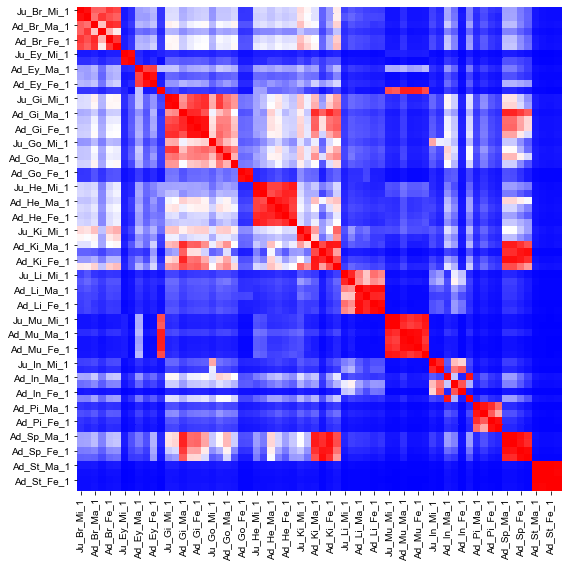

In [39]:
plt.figure(figsize=(8, 8))
seaborn.heatmap(corr, cmap="bwr", vmin=0, vmax=1, cbar=False)
plt.tight_layout()
plt.show()
plt.close()

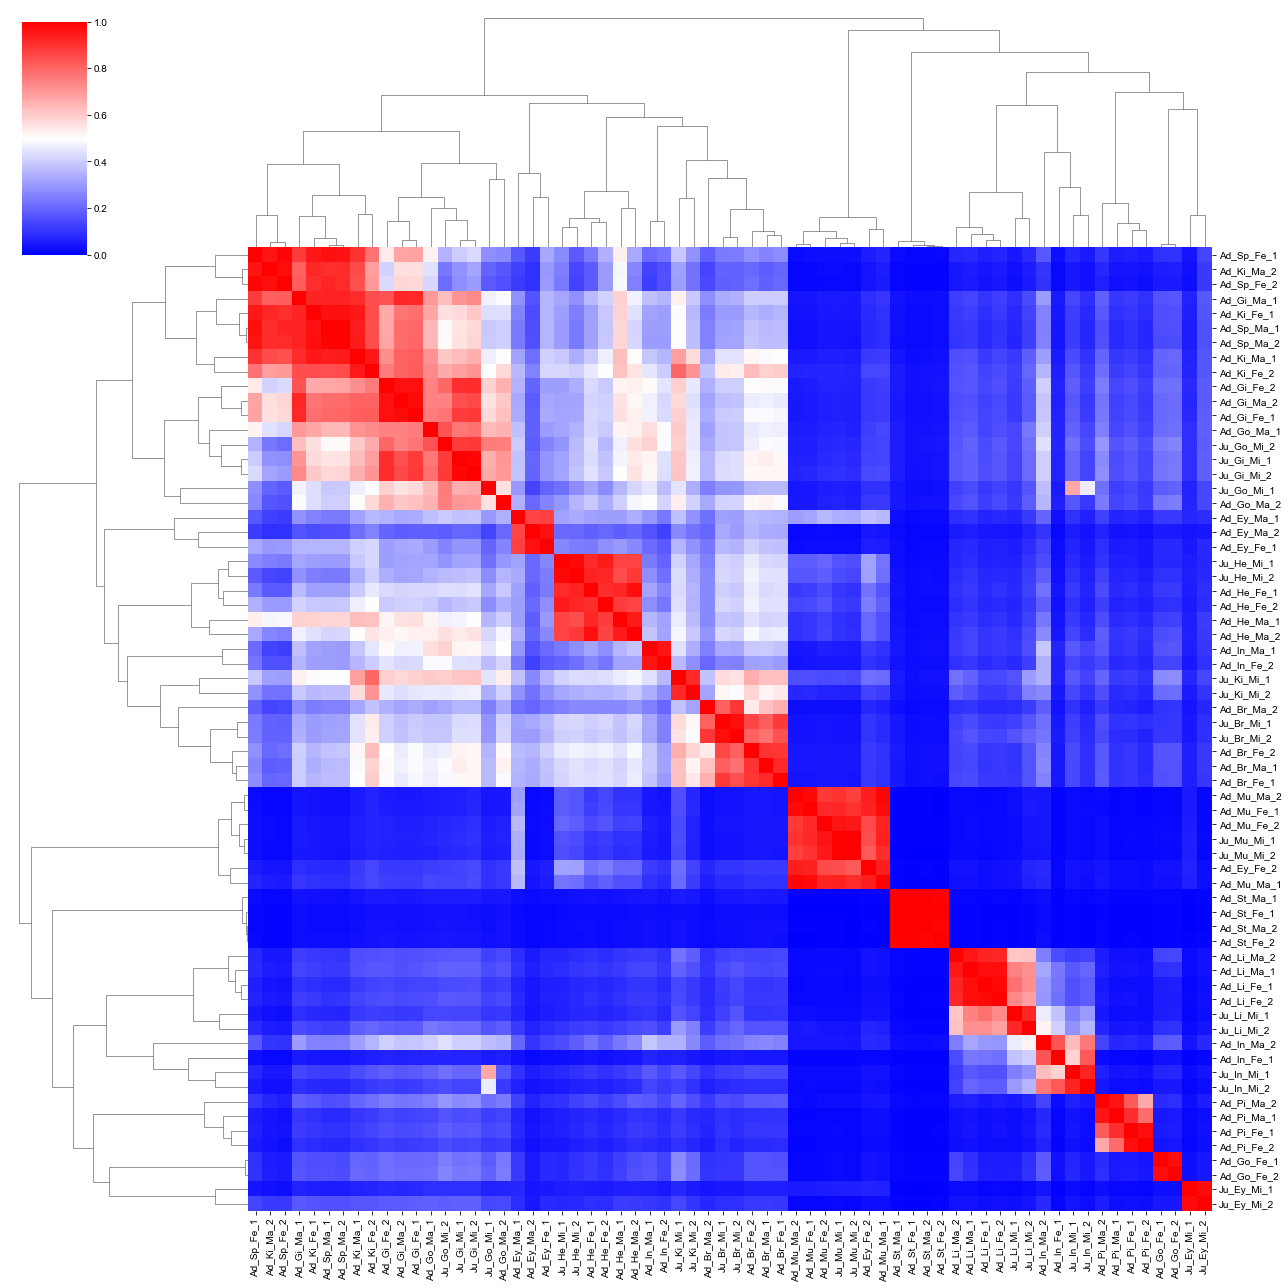

In [36]:
ret = seaborn.clustermap(corr, cmap="bwr", vmin=0, vmax=1, figsize=(18, 18), cbar=True)
# plt.tight_layout()
ret.fig.show()

# Plot rMATS

In [3]:
groups = [
    'Ad_Br_Fe', 'Ad_Br_Ma', 'Ad_Ey_Fe', 'Ad_Ey_Ma',
    'Ad_Gi_Fe', 'Ad_Gi_Ma', 'Ad_Go_Fe', 'Ad_Go_Ma',
    'Ad_He_Fe', 'Ad_He_Ma', 'Ad_In_Fe', 'Ad_In_Ma',
    'Ad_Ki_Fe', 'Ad_Ki_Ma', 'Ad_Li_Fe', 'Ad_Li_Ma',
    'Ad_Mu_Fe', 'Ad_Mu_Ma', 'Ad_Pi_Fe', 'Ad_Pi_Ma',
    'Ad_Sp_Fe', 'Ad_Sp_Ma', 'Ad_St_Fe', 'Ad_St_Ma',
    'Ju_Br_Mi', 'Ju_Ey_Mi', 'Ju_Gi_Mi', 'Ju_Go_Mi',
    'Ju_He_Mi', 'Ju_In_Mi', 'Ju_Ki_Mi', 'Ju_Li_Mi',
    'Ju_Mu_Mi'
]

In [4]:
data = dict()
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        group1 = groups[i]
        group2 = groups[j]
        path = "results/rMATS/pairs/%s_vs_%s/summary.txt" % (group1, group2)
        dat = pd.read_csv(path, sep="\t", index_col=0)
        data[(group1, group2)] = dat

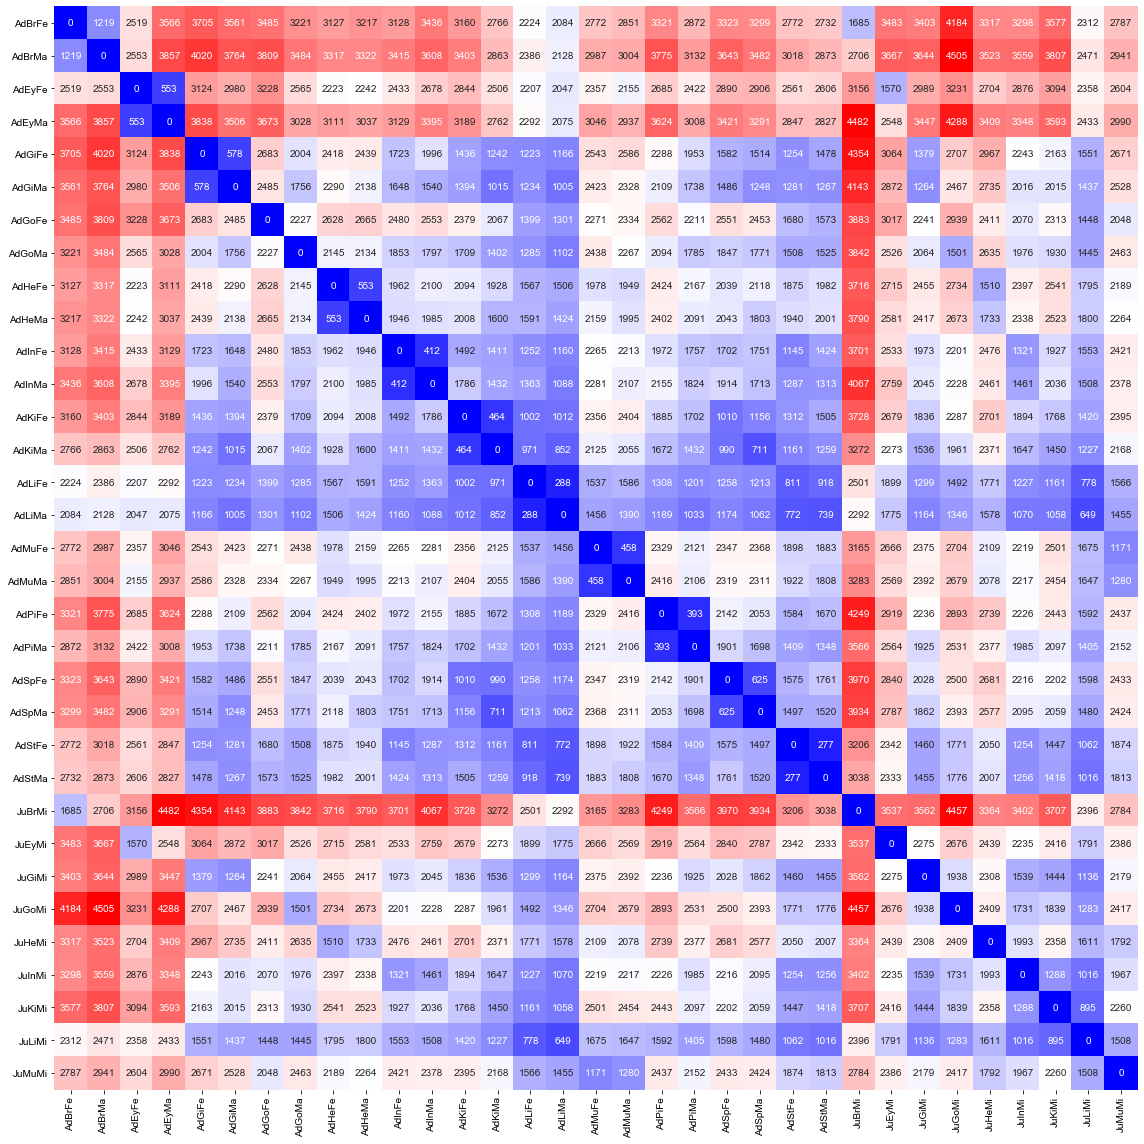

In [149]:
matrix = np.zeros((len(groups), len(groups)))
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        group1 = groups[i]
        group2 = groups[j]
        dat = data[(group1, group2)]
        value = dat.loc["SE"]["SignificantEventsJC"]
        # value = dat["SignificantEventsJC"].sum()
        matrix[i][j] = value
        matrix[j][i] = value
tmp = [g.replace("_", "") for g in groups]
matrix = pd.DataFrame(matrix, index=tmp, columns=tmp, dtype=np.int)

plt.figure(figsize=(16, 16))
seaborn.heatmap(matrix, cmap="bwr", annot=True, fmt="d", cbar=False)
plt.tight_layout()
plt.show()
plt.close()

In [12]:
for name in ["SE", "A5SS", "A3SS", "MXE", "RI"]:
    matrix = np.zeros((len(groups), len(groups)))
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            group1 = groups[i]
            group2 = groups[j]
            dat = data[(group1, group2)]
            value = dat.loc[name]["SignificantEventsJC"]
            # value = dat["SignificantEventsJC"].sum()
            matrix[i][j] = value
            matrix[j][i] = value
    matrix = pd.DataFrame(matrix, index=groups, columns=groups, dtype=np.int)
    vmax = matrix.max().max()

    plt.figure(figsize=(16, 16))
    seaborn.heatmap(matrix, cmap="bwr", annot=True, fmt="d", cbar=False, vmin=vmax * 0.3, vmax=vmax)
    plt.tight_layout()
    # plt.show()
    plt.savefig("figures/Event.%s.heatmap.png" % name, dpi=300)
    plt.close()

In [ ]:
gtf = "results/stringtie/taco/merged/assembly.sorted.gtf"

In [109]:
with open("run.rMATS.prep.sh", "w+") as fw1:
    for i in range(len(groups)):
        path1 = "results/mapping/filtered/%s.bam" % mapper2[groups[i] + "_1"]
        path2 = "results/mapping/filtered/%s.bam" % mapper2[groups[i] + "_2"]
        outdir = "results/rMATS/prep/%s" % groups[i]
        tmpdir = "results/rMATS/prep/%s.tmp" % groups[i]
        if not os.path.exists(outdir):
            os.mkdir(outdir)
        if not os.path.exists(tmpdir):
            os.mkdir(tmpdir)
        with open(outdir + "/paths.txt", "w+") as fw:
            fw.write("%s,%s\n" % (path1, path2))
        cmd = "rmats.py --b1 %s --gtf %s -t paired --readLength 50 --nthread 2 --od %s --tmp %s --task prep" % (outdir + "/paths.txt", gtf, outdir, tmpdir)
        fw1.write(cmd + "\n")

In [ ]:
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        group1 = groups[i]
        group2 = groups[j]
        path1 = "results/rMATS/prep/%s/paths.txt" % group1
        path2 = "results/rMATS/prep/%s/paths.txt" % group2
        cmd = "rmats.py --b1 %s --b2 %s --gtf %s -t paired --readLength 100 --variable-read-length --nthread 4 --libType fr-firststrand --od %s --tmp %s" % (path1, path2, gtf, )

# 2020-08-19 Plot expression of genes

In [1]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.BaseLoader)
samples = config["samples"]

In [3]:
array = []
for sample in samples:
    path = "results/expression/fpkm/raw/%s.tsv" % sample
    dat = pd.read_csv(path, sep="\t", index_col=0, header=0)
    s = dat["FPKM"]
    s.name = sample
    array.append(s)
dat = pd.concat(array, axis=1)

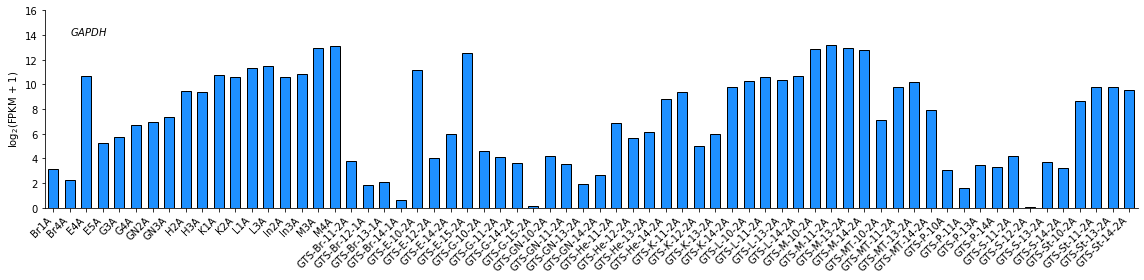

In [5]:
xticks = dat.columns
xs = np.arange(len(xticks))
ys = dat.loc["rna-XM_022756659.1"]
ys = np.log2(1 + ys)

plt.figure(figsize=(16, 4))
plt.bar(xs, ys, width=0.6, color="dodgerblue", lw=1, edgecolor="black")
plt.xticks(xs, xticks, rotation=45, ha="right")
plt.xlim(xs[0] - 0.5, xs[-1] + 0.5)
plt.ylabel("log$_2$(FPKM + 1)")
plt.ylim(0, 16)
plt.text(1, 14, "${GAPDH}$", weight="bold")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.show()
plt.close()

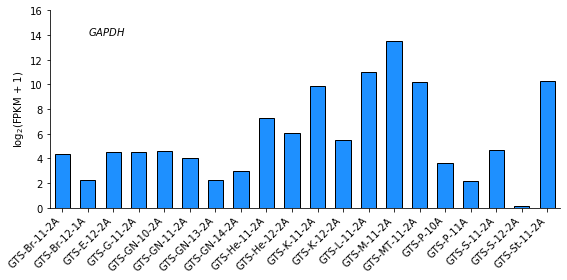

In [4]:
xticks = dat.columns
xs = np.arange(len(xticks))
ys = dat.loc["rna-XM_022756659.1"]
ys = np.log2(1 + ys)

plt.figure(figsize=(8, 4))
plt.bar(xs, ys, width=0.6, color="dodgerblue", lw=1, edgecolor="black")
plt.xticks(xs, xticks, rotation=45, ha="right")
plt.xlim(xs[0] - 0.5, xs[-1] + 0.5)
plt.ylabel("log$_2$(FPKM + 1)")
plt.ylim(0, 16)
plt.text(1, 14, "${GAPDH}$", weight="bold")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.show()
plt.close()

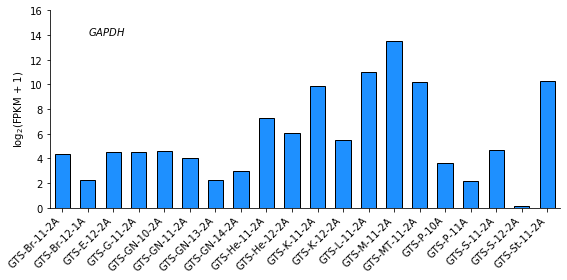

In [7]:
xticks = dat.columns
xs = np.arange(len(xticks))
ys = dat.loc["rna-XM_022756659.1"]
ys = np.log2(1 + ys)

plt.figure(figsize=(8, 4))
plt.bar(xs, ys, width=0.6, color="dodgerblue", lw=1, edgecolor="black")
plt.xticks(xs, xticks, rotation=45, ha="right")
plt.xlim(xs[0] - 0.5, xs[-1] + 0.5)
plt.ylabel("log$_2$(FPKM + 1)")
plt.ylim(0, 16)
plt.text(1, 14, "${GAPDH}$", weight="bold")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.show()
# plt.savefig("figures/gapdh.bar.png", dpi=300)
plt.close()

In [53]:
xticks = dat.columns
xs = np.arange(len(xticks))
ys = dat.loc["rna-XM_022757055.1"]
ys = np.log2(1 + ys)

plt.figure(figsize=(8, 4))
plt.bar(xs, ys, width=0.6, color="dodgerblue", lw=1, edgecolor="black")
plt.xticks(xs, xticks, rotation=45, ha="right")
plt.xlim(xs[0] - 0.5, xs[-1] + 0.5)
plt.ylabel("log$_2$(FPKM + 1)")
plt.ylim(0, 14)
plt.text(1, 12, "${ACTB}$", weight="bold")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
# plt.show()
plt.savefig("figures/actb.bar.png", dpi=300)
plt.close()

In [54]:
xticks = dat.columns
xs = np.arange(len(xticks))
ys = dat.loc["rna-XM_022762348.1"]
ys = np.log2(1 + ys)

plt.figure(figsize=(8, 4))
plt.bar(xs, ys, width=0.6, color="dodgerblue", lw=1, edgecolor="black")
plt.xticks(xs, xticks, rotation=45, ha="right")
plt.xlim(xs[0] - 0.5, xs[-1] + 0.5)
plt.ylabel("log$_2$(FPKM + 1)")
plt.ylim(0, 14)
plt.text(1, 12, "${ALDOC}$", weight="bold")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
# plt.show()
plt.savefig("figures/aldoc.bar.png", dpi=300)
plt.close()

In [55]:
xticks = dat.columns
xs = np.arange(len(xticks))
ys = dat.loc["rna-XM_022762501.1"]
ys = np.log2(1 + ys)

plt.figure(figsize=(8, 4))
plt.bar(xs, ys, width=0.6, color="dodgerblue", lw=1, edgecolor="black")
plt.xticks(xs, xticks, rotation=45, ha="right")
plt.xlim(xs[0] - 0.5, xs[-1] + 0.5)
plt.ylabel("log$_2$(FPKM + 1)")
plt.ylim(0, 14)
plt.text(1, 12, "${PGK1}$", weight="bold")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
# plt.show()
plt.savefig("figures/pgk1.bar.png", dpi=300)
plt.close()

# 2020-12-08 Combine all FPKM together

In [48]:
array = []
for sample in samples:
    path = "results/expression/featureCount/%s.txt" % sample
    d = pd.read_csv(path, sep="\t", header=1, index_col=0)
    s = d[d.columns[-1]]
    s.name = name_mapper[sample]
    array.append(s)
dat = pd.concat(array, axis=1)
dat = dat[sorted(dat.columns)]
dat.to_csv("results/expression/featureCount.merged.tsv", sep="\t")

In [49]:
cpm = dat.divide(dat.sum(axis=0), axis=1) * 1e6

In [52]:
cpm_filtered = cpm[cpm.max(axis=1) > 10]
corr = cpm_filtered.corr()

In [84]:
plt.figure(figsize=(16, 16))
seaborn.heatmap(corr, cmap="bwr", vmin=0, vmax=1, cbar=False)
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/featureCount.heatmap.png", dpi=300)
plt.close()

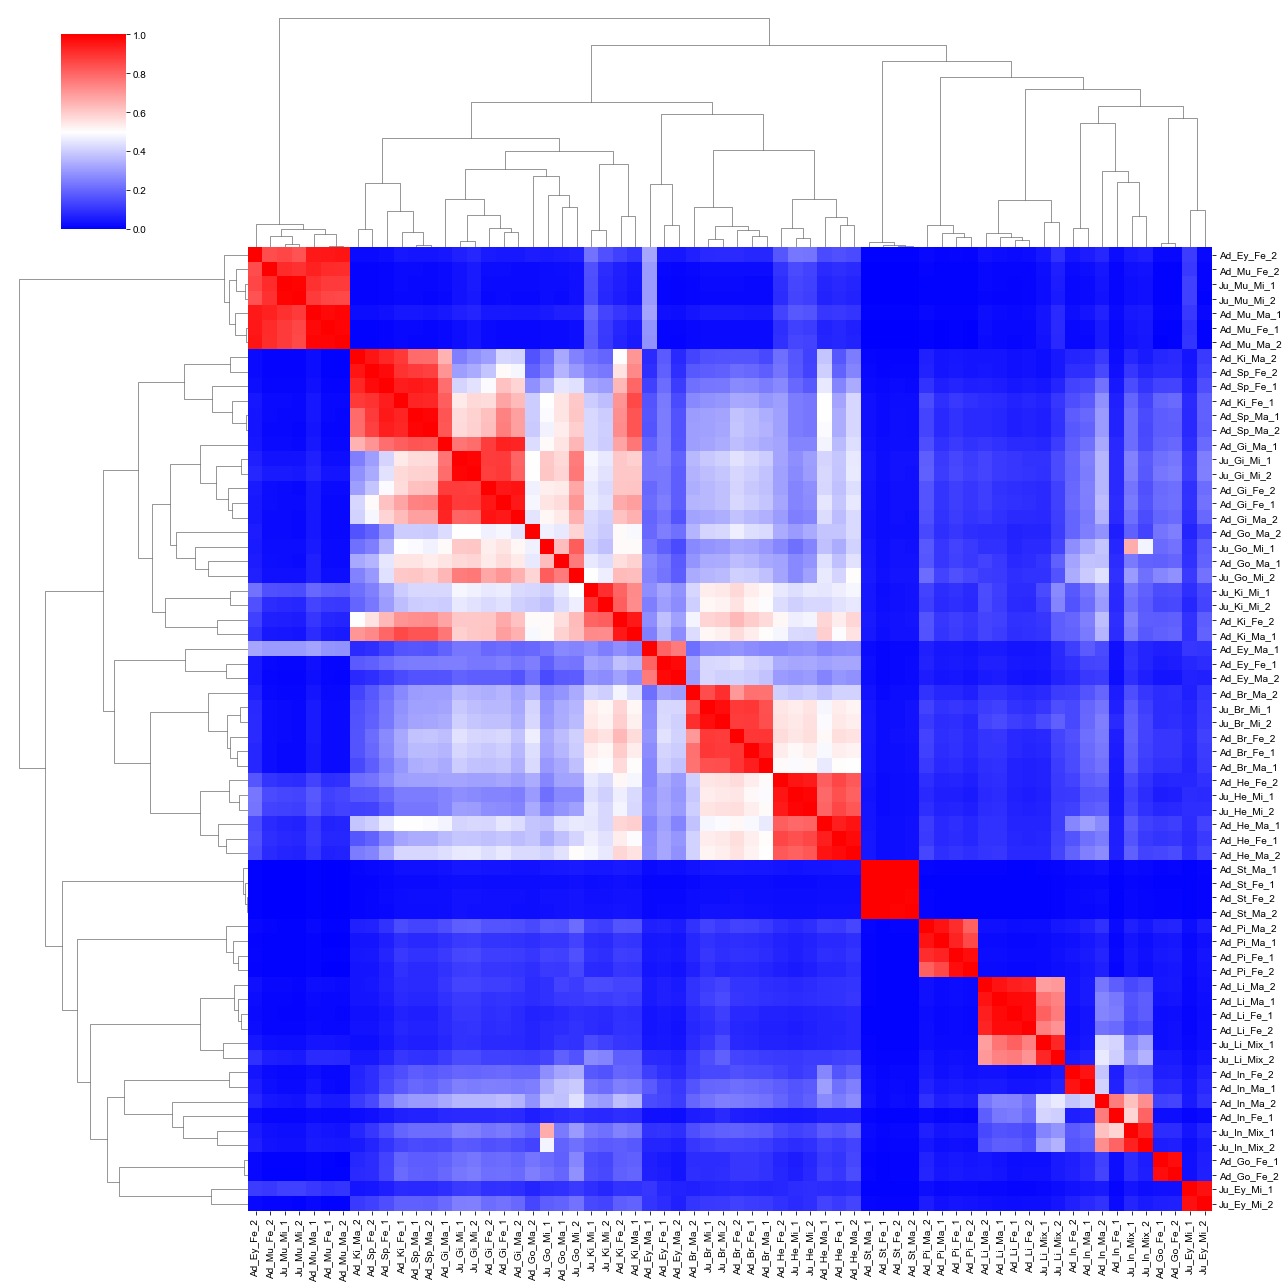

In [77]:
ret = seaborn.clustermap(corr, figsize=(18, 18), cmap="bwr",vmin=0, vmax=1, cbar_pos=(0.05, 0.82, 0.05, 0.15))

In [83]:
ret.fig.savefig("figures/featureCount.clustermap.png", dpi=300)

In [3]:
with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.BaseLoader)
samples = config["samples"]

In [6]:
mapper = {}
samples2 = [
    'Juvenile_Brain_Mix_Rep1', 'Juvenile_Brain_Mix_Rep2', 
    'Juvenile_Eye_Mix_Rep1', 'Juvenile_Eye_Mix_Rep2', 
    'Juvenile_Gill_Mix_Rep1', 'Juvenile_Gill_Mix_Rep2', 
    'Juvenile_Gonad_Mix_Rep1', 'Juvenile_Gonad_Mix_Rep2', 
    'Juvenile_Heart_Mix_Rep1', 'Juvenile_Heart_Mix_Rep2', 
    'Juvenile_Kidney_Mix_Rep1', 'Juvenile_Kidney_Mix_Rep2', 
    'Juvenile_Liver_Mix_Rep1', 'Juvenile_Liver_Mix_Rep2', 
    'Juvenile_Intestines_Mix_Rep1', 'Juvenile_Intestines_Mix_Rep2', 
    'Juvenile_Muscle_Mix_Rep1', 'Juvenile_Muscle_Mix_Rep2',
    'Adult_Brain_Male_Rep1', 'Adult_Brain_Male_Rep2', 'Adult_Brain_Female_Rep1', 'Adult_Brain_Female_Rep2',
    'Adult_Eye_Male_Rep1', 'Adult_Eye_Male_Rep2', 'Adult_Eye_Female_Rep1', 'Adult_Eye_Female_Rep2',
    'Adult_Gill_Male_Rep1', 'Adult_Gill_Male_Rep2', 'Adult_Gill_Female_Rep1', 'Adult_Gill_Female_Rep2',
    'Adult_Gonad_Male_Rep1', 'Adult_Gonad_Male_Rep2', 'Adult_Gonad_Female_Rep1', 'Adult_Gonad_Female_Rep2',
    'Adult_Heart_Male_Rep1', 'Adult_Heart_Male_Rep2', 'Adult_Heart_Female_Rep1', 'Adult_Heart_Female_Rep2',
    'Adult_Kidney_Male_Rep1', 'Adult_Kidney_Male_Rep2', 'Adult_Kidney_Female_Rep1', 'Adult_Kidney_Female_Rep2',
    'Adult_Liver_Male_Rep1', 'Adult_Liver_Male_Rep2', 'Adult_Liver_Female_Rep1', 'Adult_Liver_Female_Rep2',
    'Adult_Muscle_Male_Rep1', 'Adult_Muscle_Male_Rep2', 'Adult_Muscle_Female_Rep1', 'Adult_Muscle_Female_Rep2',
    'Adult_Intestines_Male_Rep1', 'Adult_Intestines_Male_Rep2', 'Adult_Intestines_Female_Rep1', 'Adult_Intestines_Female_Rep2',
    'Adult_Pituitary_Male_Rep1', 'Adult_Pituitary_Male_Rep2', 'Adult_Pituitary_Female_Rep1', 'Adult_Pituitary_Female_Rep2',
    'Adult_Spleen_Male_Rep1', 'Adult_Spleen_Male_Rep2', 'Adult_Spleen_Female_Rep1', 'Adult_Spleen_Female_Rep2',
    'Adult_Stomach_Male_Rep1', 'Adult_Stomach_Male_Rep2', 'Adult_Stomach_Female_Rep1', 'Adult_Stomach_Female_Rep2',
]
for s1, s2 in zip(samples, samples2):
    mapper[s1] = s2
mapper

{'Br1A': 'Juvenile_Brain_Mix_Rep1',
 'Br4A': 'Juvenile_Brain_Mix_Rep2',
 'E4A': 'Juvenile_Eye_Mix_Rep1',
 'E5A': 'Juvenile_Eye_Mix_Rep2',
 'G3A': 'Juvenile_Gill_Mix_Rep1',
 'G4A': 'Juvenile_Gill_Mix_Rep2',
 'GN2A': 'Juvenile_Gonad_Mix_Rep1',
 'GN3A': 'Juvenile_Gonad_Mix_Rep2',
 'H2A': 'Juvenile_Heart_Mix_Rep1',
 'H3A': 'Juvenile_Heart_Mix_Rep2',
 'K1A': 'Juvenile_Kidney_Mix_Rep1',
 'K2A': 'Juvenile_Kidney_Mix_Rep2',
 'L1A': 'Juvenile_Liver_Mix_Rep1',
 'L3A': 'Juvenile_Liver_Mix_Rep2',
 'ln2A': 'Juvenile_Intestines_Mix_Rep1',
 'ln3A': 'Juvenile_Intestines_Mix_Rep2',
 'M3A': 'Juvenile_Muscle_Mix_Rep1',
 'M4A': 'Juvenile_Muscle_Mix_Rep2',
 'GTS-Br-11-2A': 'Adult_Brain_Male_Rep1',
 'GTS-Br-12-1A': 'Adult_Brain_Male_Rep2',
 'GTS-Br-13-1A': 'Adult_Brain_Female_Rep1',
 'GTS-Br-14-1A': 'Adult_Brain_Female_Rep2',
 'GTS-E-10-2A': 'Adult_Eye_Male_Rep1',
 'GTS-E-12-2A': 'Adult_Eye_Male_Rep2',
 'GTS-E-14-2A': 'Adult_Eye_Female_Rep1',
 'GTS-E-15-2A': 'Adult_Eye_Female_Rep2',
 'GTS-G-10-2A': 'Adult_G

In [3]:
array = []
for sample in samples:
    path = "results/expression/fpkm/raw/%s.tsv" % sample
    dat = pd.read_csv(path, sep="\t", index_col=0, header=0)
    fpkms = dat["FPKM"]
    fpkms.name = sample
    array.append(fpkms)
combine = pd.concat(array, axis=1)
combine.columns = [
    'Juvenile_Brain_Mix_Rep1', 'Juvenile_Brain_Mix_Rep2', 
    'Juvenile_Eye_Mix_Rep1', 'Juvenile_Eye_Mix_Rep2', 
    'Juvenile_Gill_Mix_Rep1', 'Juvenile_Gill_Mix_Rep2', 
    'Juvenile_Gonad_Mix_Rep1', 'Juvenile_Gonad_Mix_Rep2', 
    'Juvenile_Heart_Mix_Rep1', 'Juvenile_Heart_Mix_Rep2', 
    'Juvenile_Kidney_Mix_Rep1', 'Juvenile_Kidney_Mix_Rep2', 
    'Juvenile_Liver_Mix_Rep1', 'Juvenile_Liver_Mix_Rep2', 
    'Juvenile_Intestines_Mix_Rep1', 'Juvenile_Intestines_Mix_Rep2', 
    'Juvenile_Muscle_Mix_Rep1', 'Juvenile_Muscle_Mix_Rep2',
    'Adult_Brain_Male_Rep1', 'Adult_Brain_Male_Rep2', 'Adult_Brain_Female_Rep1', 'Adult_Brain_Female_Rep2',
    'Adult_Eye_Male_Rep1', 'Adult_Eye_Male_Rep2', 'Adult_Eye_Female_Rep1', 'Adult_Eye_Female_Rep2',
    'Adult_Gill_Male_Rep1', 'Adult_Gill_Male_Rep2', 'Adult_Gill_Female_Rep1', 'Adult_Gill_Female_Rep2',
    'Adult_Gonad_Male_Rep1', 'Adult_Gonad_Male_Rep2', 'Adult_Gonad_Female_Rep1', 'Adult_Gonad_Female_Rep2',
    'Adult_Heart_Male_Rep1', 'Adult_Heart_Male_Rep2', 'Adult_Heart_Female_Rep1', 'Adult_Heart_Female_Rep2',
    'Adult_Kidney_Male_Rep1', 'Adult_Kidney_Male_Rep2', 'Adult_Kidney_Female_Rep1', 'Adult_Kidney_Female_Rep2',
    'Adult_Liver_Male_Rep1', 'Adult_Liver_Male_Rep2', 'Adult_Liver_Female_Rep1', 'Adult_Liver_Female_Rep2',
    'Adult_Muscle_Male_Rep1', 'Adult_Muscle_Male_Rep2', 'Adult_Muscle_Female_Rep1', 'Adult_Muscle_Female_Rep2',
    'Adult_Intestines_Male_Rep1', 'Adult_Intestines_Male_Rep2', 'Adult_Intestines_Female_Rep1', 'Adult_Intestines_Female_Rep2',
    'Adult_Pituitary_Male_Rep1', 'Adult_Pituitary_Male_Rep2', 'Adult_Pituitary_Female_Rep1', 'Adult_Pituitary_Female_Rep2',
    'Adult_Spleen_Male_Rep1', 'Adult_Spleen_Male_Rep2', 'Adult_Spleen_Female_Rep1', 'Adult_Spleen_Female_Rep2',
    'Adult_Stomach_Male_Rep1', 'Adult_Stomach_Male_Rep2', 'Adult_Stomach_Female_Rep1', 'Adult_Stomach_Female_Rep2',
]

In [16]:
combine.to_csv("results/expression/fpkm/combined.tsv", sep="\t")

In [4]:
anno = pd.read_csv("data/genome/annotation.tsv", sep="\t", index_col=0, header=0)
annotated = combine.merge(anno, left_index=True, right_index=True)

In [5]:
annotated.to_csv("results/expression/fpkm/combined.annotated.tsv", sep="\t")

# Correlaton between samples

In [6]:
dat = pd.read_csv("results/expression/fpkm/combined.annotated.tsv", sep="\t", index_col=0)
dat = dat[(dat["BioType"] == "protein_coding") & (dat["Longest"])]
dat = dat[dat.columns[:-9]]

In [7]:
stds = dat.std(axis=1)
means = dat.mean(axis=1)
subs = dat.subtract(means, axis=0)
zscores = subs.divide(stds, axis=0)

15669


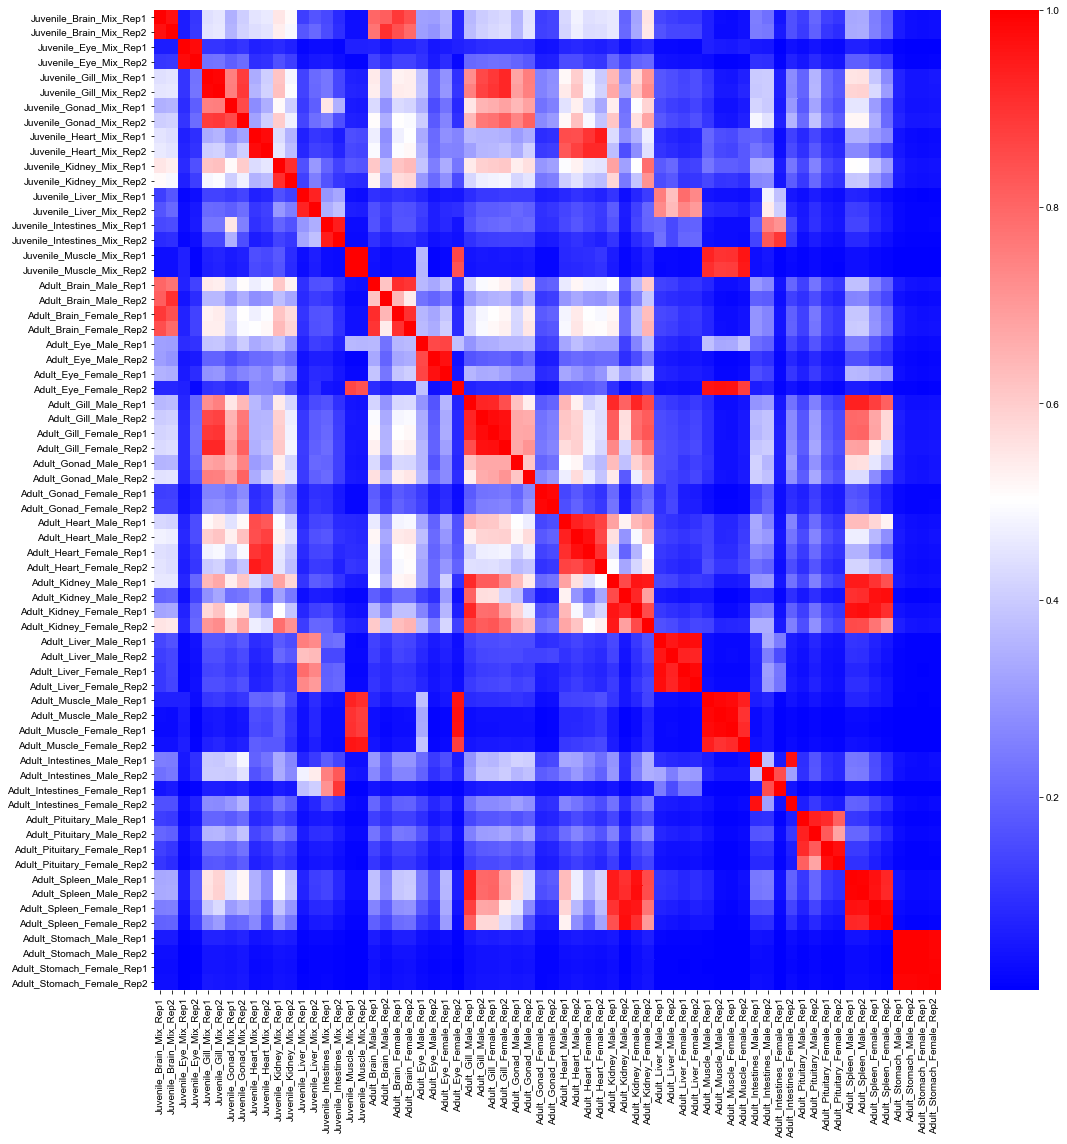

In [10]:
dat1 = dat[dat.max(axis=1) > 10]
print(len(dat1))

matrix = dat1.corr()

plt.figure(figsize=(16, 16))
seaborn.heatmap(matrix, cmap="bwr")
plt.tight_layout()
if True:
    plt.show()
else:
    plt.savefig("figures/heatmap.png", dpi=300)
plt.close()

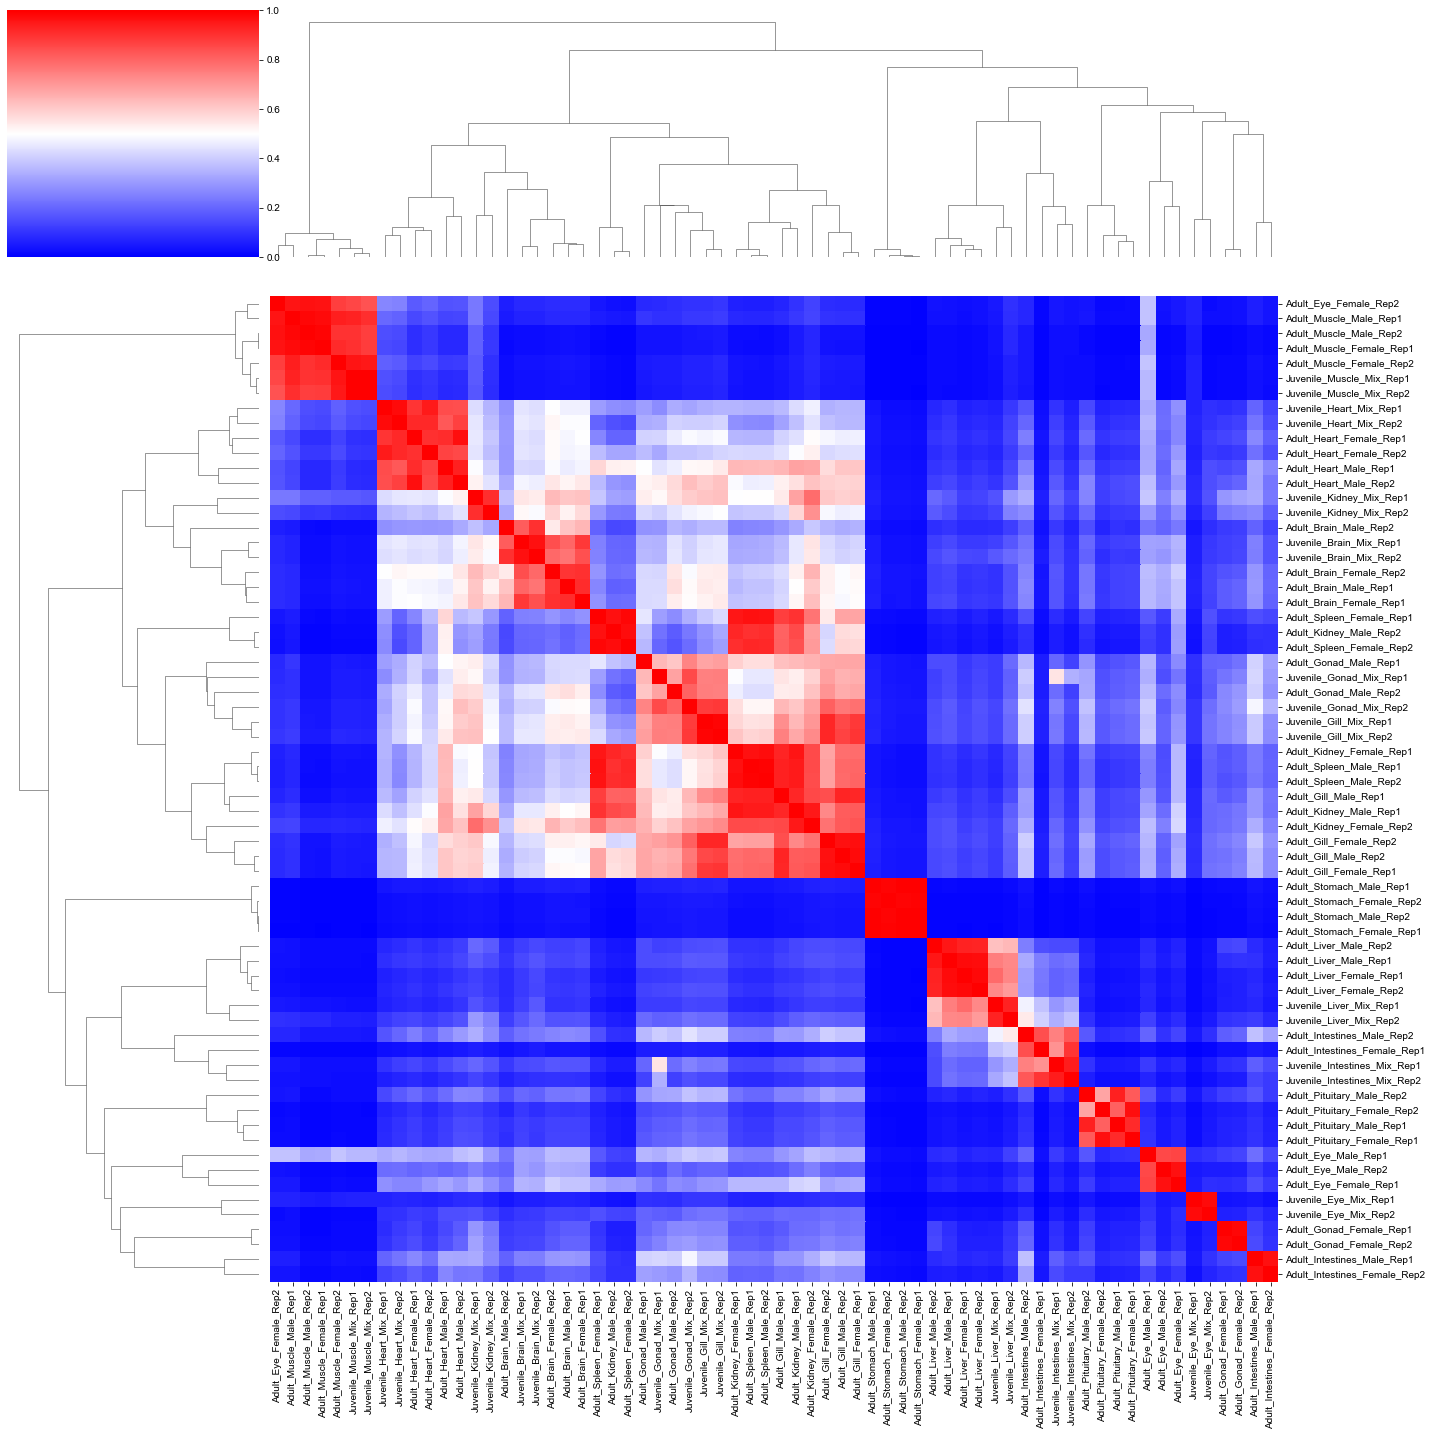

In [11]:
seaborn.clustermap(matrix, cmap="bwr", figsize=(20, 20), vmin=0, vmax=1)
plt.tight_layout()
if True:
    plt.show()
else:
    plt.savefig("figures/clustermap.pdf", dpi=300)
plt.close()

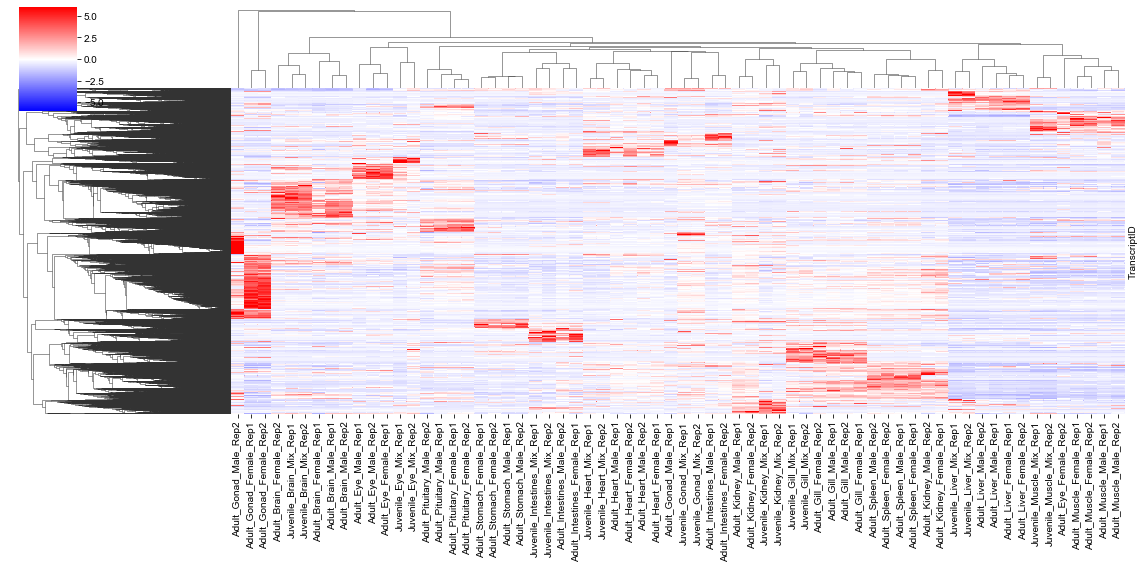

In [133]:
ret = seaborn.clustermap(dat1, z_score=0, cmap="bwr", figsize=(16, 8), xticklabels=True, yticklabels=False, vmin=-6, vmax=6)
if True:
    ret.fig.savefig("figures/cluster.genes.png", dpi=300)

# 成鱼垂体

In [4]:
dat = pd.read_csv("results/expression/fpkm/combined.annotated.tsv", sep="\t", index_col=0)
dat = dat[(dat["BioType"] == "protein_coding") & (dat["Longest"])]
dat = dat[dat.columns[:-9]]
dat1 = dat[["Adult_Pituitary_Male_Rep1", "Adult_Pituitary_Male_Rep2", "Adult_Pituitary_Female_Rep1", "Adult_Pituitary_Female_Rep2"]]
dat2 = dat1[dat1.max(axis=1) > 10]

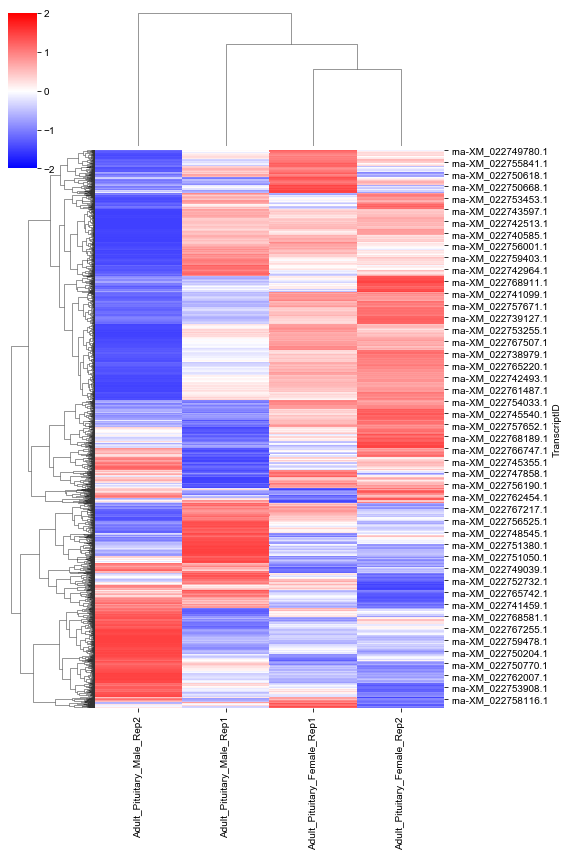

In [19]:
ret = seaborn.clustermap(dat2, z_score=0, cmap="bwr", figsize=(8, 12), xticklabels=True, vmin=-2, vmax=2)

In [59]:
values1 = []
values2 = []
for vs in dat2.values:
    vs1 = vs[:2]
    vs2 = vs[2:4]
    log2fc = np.log2(np.divide(np.mean(vs2), np.mean(vs1)))
    stat, pvalue = ttest_ind(vs1, vs2)
    values1.append(log2fc)
    values2.append(pvalue)
dat2["Log2FC"] = values1
dat2["Pvalue"] = values2
dat2["Log10P"] = -np.log10(dat2["Pvalue"])

/home/chenzonggui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/chenzonggui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/chenzonggui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

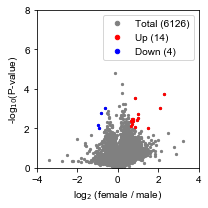

In [58]:
xs = dat2["Log2FC"]
ys = -np.log10(dat2["Pvalue"])

xs1 = []
ys1 = []
xs2 = []
ys2 = []
for x, y in zip(xs, ys):
    if x > np.log2(1.5) and y > 2:
        xs1.append(x)
        ys1.append(y)
    if x < -np.log2(1.5) and y > 2:
        xs2.append(x)
        ys2.append(y)

plt.figure(figsize=(3, 3))
plt.scatter(xs, ys, color="grey", marker=".", s=20, label="Total (%d)" % len(xs))
plt.scatter(xs1, ys1, color="red", marker=".", s=20, label="Up (%d)" % len(xs1))
plt.scatter(xs2, ys2, color="blue", marker=".", s=20, label="Down (%d)" % len(xs2))
plt.xlim(-4, 4)
plt.xticks([-4, -2, 0, 2, 4])
plt.ylim(0, 8)
plt.yticks([0, 2, 4, 6, 8])
plt.xlabel("log$_2$ (female / male)")
plt.ylabel("-log$_{10}$(P-value)")
plt.legend(frameon=True, markerscale=2)
plt.tight_layout()
if True:
    plt.show()
else:
    plt.savefig("figures/Pituitary.png", dpi=300)
plt.close()

In [60]:
dat3 = dat2[dat2["Pvalue"] < 0.01]

In [61]:
dat4 = dat3[(dat3["Log2FC"] > np.log2(1.5)) | (dat3["Log2FC"] < -np.log2(1.5))]

In [62]:
dat5 = dat4.merge(anno, left_index=True, right_index=True, how="left")
dat5.to_csv("Pituitary.degs.tsv", sep="\t")

In [34]:
dat3_up = dat3[dat3["Log2FC"] > np.log2(1.5)]
dat3_do = dat3[dat3["Log2FC"] < -np.log2(1.5)]

In [36]:
dat3_up

,Adult_Pituitary_Male_Rep1,Adult_Pituitary_Male_Rep2,Adult_Pituitary_Female_Rep1,Adult_Pituitary_Female_Rep2,Log2FC,Pvalue
TranscriptID,,,,,,
rna-XM_022740831.1,8.440717,7.625513,15.929218,15.722211,0.978239,0.002900
rna-XM_022751990.1,12.218484,11.827427,20.219451,19.424860,0.721322,0.003208
rna-XM_022770394.1,64.855694,63.313973,98.050778,102.469522,0.645693,0.004158
rna-XM_022742660.1,2.116553,2.201449,10.764668,10.549460,2.303374,0.000185
rna-XM_022747970.1,10.010368,9.006504,41.354117,39.792898,2.093258,0.000891
rna-XM_022748668.1,13.964499,11.593937,34.404920,38.286177,1.507979,0.009183
rna-XM_022749149.1,51.068970,49.611409,84.562240,79.773202,0.706861,0.006128
rna-XM_022751591.1,6.954683,6.896880,12.415149,12.599890,0.852747,0.000301
rna-XM_022760044.1,29.195209,25.603094,48.337912,50.321360,0.848323,0.008639


In [37]:
dat3_do

,Adult_Pituitary_Male_Rep1,Adult_Pituitary_Male_Rep2,Adult_Pituitary_Female_Rep1,Adult_Pituitary_Female_Rep2,Log2FC,Pvalue
TranscriptID,,,,,,
rna-XM_022749039.1,35.836516,35.089236,22.893328,22.733621,-0.636423,0.000911
rna-XM_022750041.1,14.645229,13.401423,7.507300,7.136869,-0.937502,0.009247
rna-XM_022750110.1,46.155520,43.661387,21.416611,24.159255,-0.978717,0.006948
rna-XM_022754719.1,38.322657,36.957609,20.796217,21.131548,-0.844366,0.001771


In [37]:
anno = pd.read_csv("data/genome/annotation.tsv", sep="\t", index_col=0)
info = pd.read_csv("data/Sdu_1.0/product.info.tsv", sep="\t")
info = info[~info["Gene"].duplicated()]
products = dict()
for gene, product in info.values:
    products[gene] = product
values = []
for gname in anno["GeneName"]:
    if isinstance(gname, str):
        values.append(products.get(gname, ""))
    else:
        values.append("")
anno["Product"] = values

# 性腺

In [22]:
anno = pd.read_csv("data/genome/annotation.tsv", sep="\t", index_col=0)
info = pd.read_csv("data/Sdu_1.0/product.info.tsv", sep="\t")
info = info[~info["Gene"].duplicated()]
products = dict()
for gene, product in info.values:
    products[gene] = product
values = []
for gname in anno["GeneName"]:
    if isinstance(gname, str):
        values.append(products.get(gname, ""))
    else:
        values.append("")
anno["Product"] = values

In [4]:
dat = pd.read_csv("results/expression/fpkm/combined.annotated.tsv", sep="\t", index_col=0)
dat = dat[(dat["BioType"] == "protein_coding") & (dat["Longest"])]
dat = dat[dat.columns[:-9]]
# dat1 = dat[["Adult_Pituitary_Male_Rep1", "Adult_Pituitary_Male_Rep2", "Adult_Pituitary_Female_Rep1", "Adult_Pituitary_Female_Rep2"]]
# dat2 = dat1[dat1.max(axis=1) > 10]

In [5]:
stds = dat.std(axis=1)
means = dat.mean(axis=1)
subs = dat.subtract(means, axis=0)
zscores = subs.divide(stds, axis=0)

In [15]:
flags = []
for vs in zscores[["Adult_Gonad_Male_Rep2", "Adult_Gonad_Female_Rep1", "Adult_Gonad_Female_Rep2"]].values:
    vmin = min(vs)
    flags.append(vmin >= 3)

In [18]:
dat1 = dat[flags]
dat2 = dat1[dat1.max(axis=1) > 10]
print(len(dat2))

233


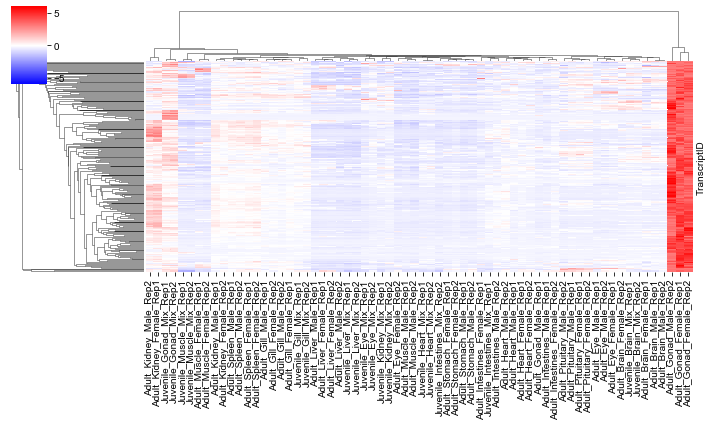

In [75]:
ret = seaborn.clustermap(dat2, z_score=0, cmap="bwr", figsize=(10, 6), xticklabels=True, yticklabels=False, vmin=-6, vmax=6)
ret.fig.savefig("figures/gonad.heatmap.png", dpi=300)

In [24]:
dat3 = dat2.merge(anno, left_index=True, right_index=True, how="left")
dat3.to_csv("Adult_Gonad.tsv", sep="\t")

In [ ]:
# rna-XM_022738890.1 crcp CGRP receptor component
# rna-XM_022762004.1 LOC111234088 gonadotropin-releasing hormone II receptor-like

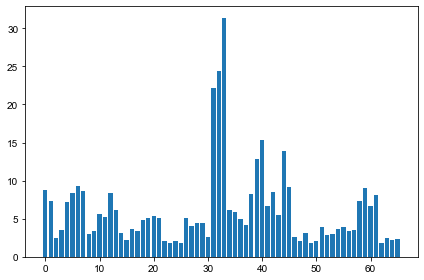

In [35]:
ys = dat.loc["rna-XM_022738890.1"]
xs = range(len(ys))
xticks = dat.columns

plt.figure()
plt.bar(xs, ys)
plt.tight_layout()
plt.show()
plt.close()

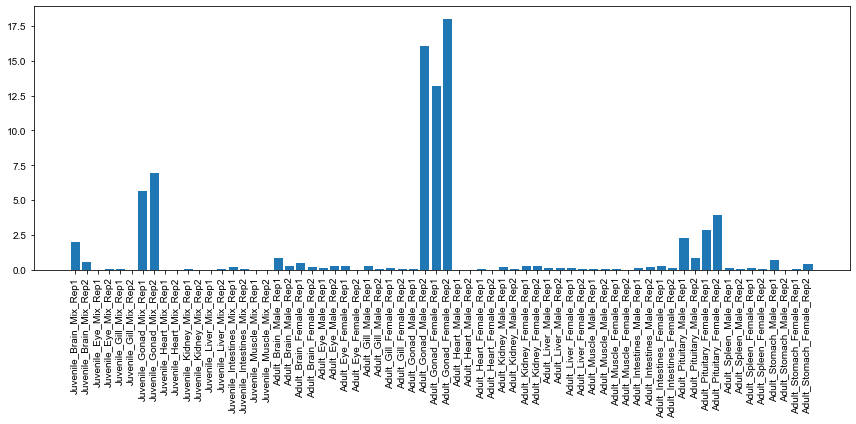

In [36]:
ys = dat.loc["rna-XM_022762004.1"]
xs = range(len(ys))
xticks = dat.columns

plt.figure(figsize=(12, 6))
plt.bar(xs, ys)
plt.xticks(xs, xticks, rotation=90)
plt.tight_layout()
plt.show()
plt.close()

In [81]:
xticks = ["Gonad (A)", "Gonad (J)", "Pituitary", "Brain", "Others"]
vs1 = ys[["Adult_Gonad_Male_Rep2", "Adult_Gonad_Female_Rep1", "Adult_Gonad_Female_Rep2"]]
vs2 = ys[["Juvenile_Gonad_Mix_Rep1", "Juvenile_Gonad_Mix_Rep2"]]
vs3 = ys[["Adult_Pituitary_Male_Rep1", "Adult_Pituitary_Male_Rep2", "Adult_Pituitary_Female_Rep1", "Adult_Pituitary_Female_Rep2"]]
vs4 = ys[["Juvenile_Brain_Mix_Rep1", "Juvenile_Brain_Mix_Rep2", "Adult_Brain_Male_Rep1", "Adult_Brain_Male_Rep2", "Adult_Brain_Female_Rep1", "Adult_Brain_Female_Rep1"]]
vs5 = ys[[
       'Juvenile_Eye_Mix_Rep1', 'Juvenile_Eye_Mix_Rep2',
       'Juvenile_Gill_Mix_Rep1', 'Juvenile_Gill_Mix_Rep2',
       'Juvenile_Heart_Mix_Rep1', 'Juvenile_Heart_Mix_Rep2',
       'Juvenile_Kidney_Mix_Rep1', 'Juvenile_Kidney_Mix_Rep2',
       'Juvenile_Liver_Mix_Rep1', 'Juvenile_Liver_Mix_Rep2',
       'Juvenile_Intestines_Mix_Rep1', 'Juvenile_Intestines_Mix_Rep2',
       'Juvenile_Muscle_Mix_Rep1', 'Juvenile_Muscle_Mix_Rep2',
       'Adult_Eye_Male_Rep1', 'Adult_Eye_Male_Rep2', 'Adult_Eye_Female_Rep1',
       'Adult_Eye_Female_Rep2', 'Adult_Gill_Male_Rep1', 'Adult_Gill_Male_Rep2',
       'Adult_Gill_Female_Rep1', 'Adult_Gill_Female_Rep2',
       'Adult_Heart_Male_Rep1', 'Adult_Heart_Male_Rep2',
       'Adult_Heart_Female_Rep1', 'Adult_Heart_Female_Rep2',
       'Adult_Kidney_Male_Rep1', 'Adult_Kidney_Male_Rep2',
       'Adult_Kidney_Female_Rep1', 'Adult_Kidney_Female_Rep2',
       'Adult_Liver_Male_Rep1', 'Adult_Liver_Male_Rep2',
       'Adult_Liver_Female_Rep1', 'Adult_Liver_Female_Rep2',
       'Adult_Muscle_Male_Rep1', 'Adult_Muscle_Male_Rep2',
       'Adult_Muscle_Female_Rep1', 'Adult_Muscle_Female_Rep2',
       'Adult_Intestines_Male_Rep1', 'Adult_Intestines_Male_Rep2',
       'Adult_Intestines_Female_Rep1', 'Adult_Intestines_Female_Rep2',
       'Adult_Spleen_Male_Rep1', 'Adult_Spleen_Male_Rep2',
       'Adult_Spleen_Female_Rep1', 'Adult_Spleen_Female_Rep2',
       'Adult_Stomach_Male_Rep1', 'Adult_Stomach_Male_Rep2',
       'Adult_Stomach_Female_Rep1', 'Adult_Stomach_Female_Rep2']]

array = [vs1, vs2, vs3, vs4, vs5]
means = [np.mean(vs) for vs in array]
stds = [np.std(vs) for vs in array]
xs = np.arange(len(means))

plt.figure(figsize=(3, 3))
plt.bar(xs, means, lw=1, edgecolor="black", color="dodgerblue",
        yerr=stds, error_kw={"capsize": 4, "linewidth": 1})
plt.text(1.5, 17, "$LOC111234088$")
plt.xticks(xs, xticks, rotation=45)
plt.ylim(0, 20)
plt.yticks([0, 5, 10, 15, 20])
plt.ylabel("Expression (FPKM)")
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/gonad.LOC111234088.png", dpi=300)
plt.close()

rna-XM_022740281.1


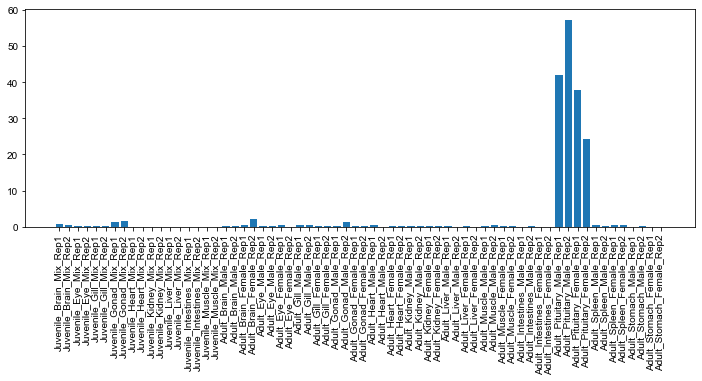

rna-XM_022741922.1


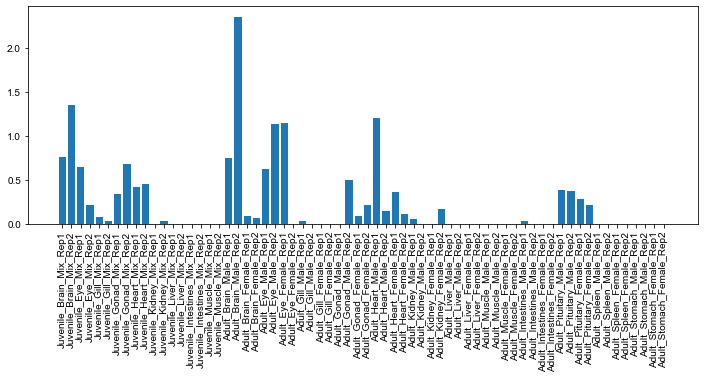

rna-XM_022748918.1


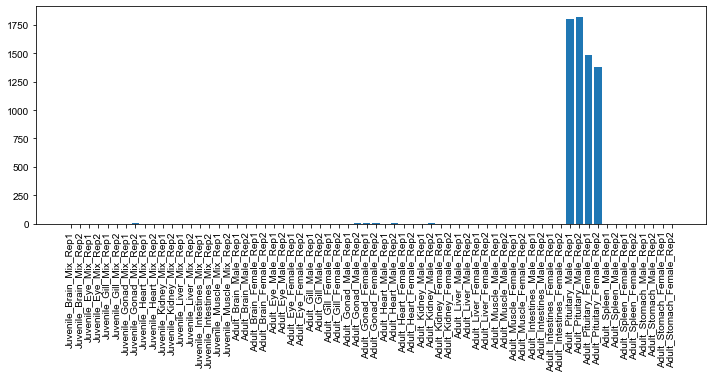

rna-XM_022756439.1


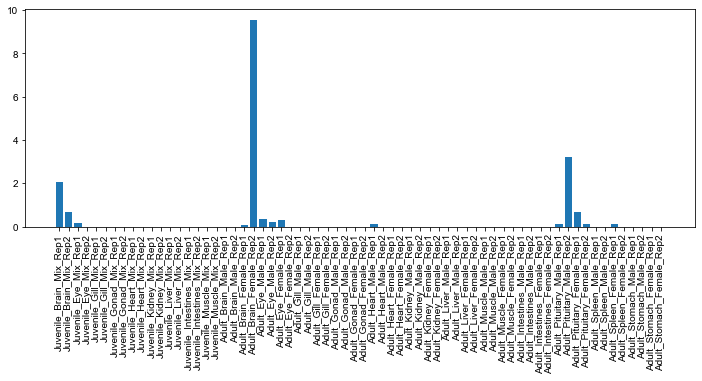

rna-XM_022756439.1


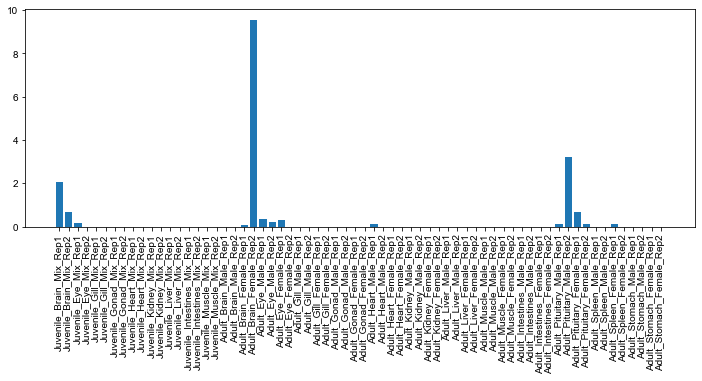

rna-XM_022743559.1


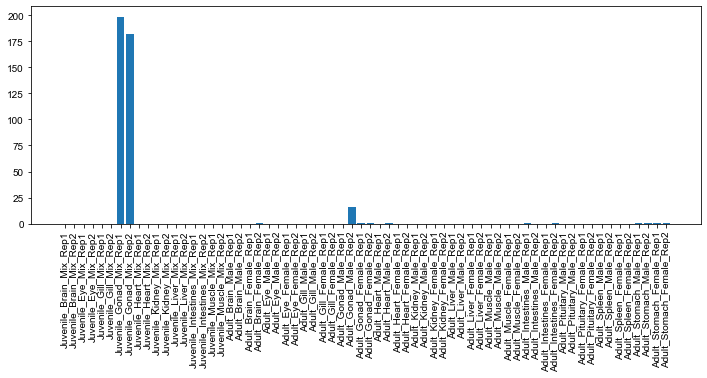

rna-XM_022743644.1


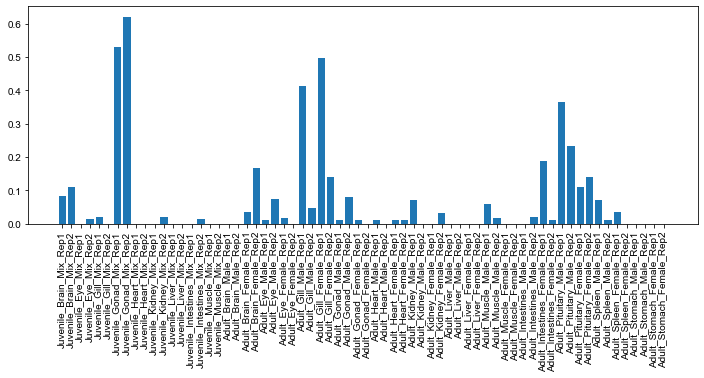

rna-XM_022743662.1


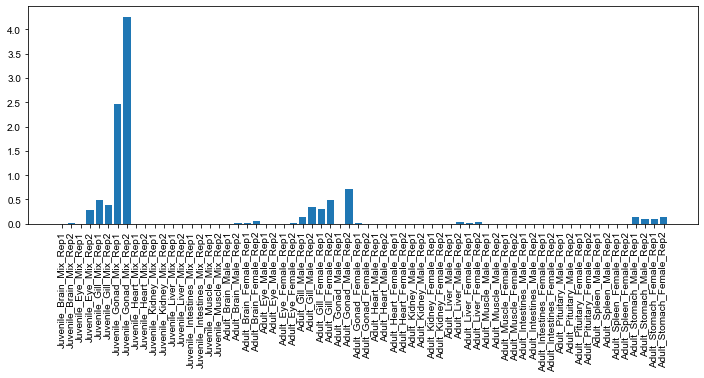

rna-XM_022743662.1


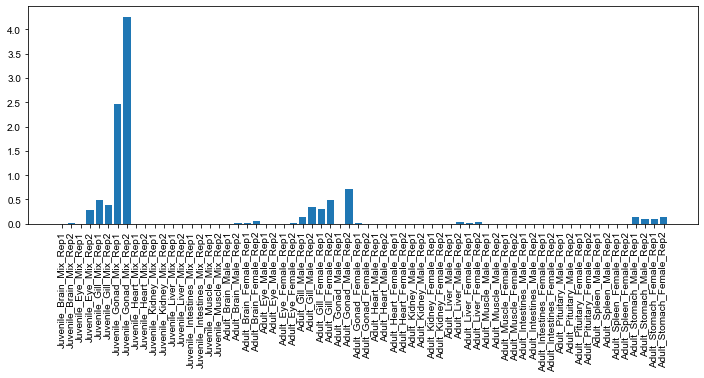

rna-XM_022745163.1


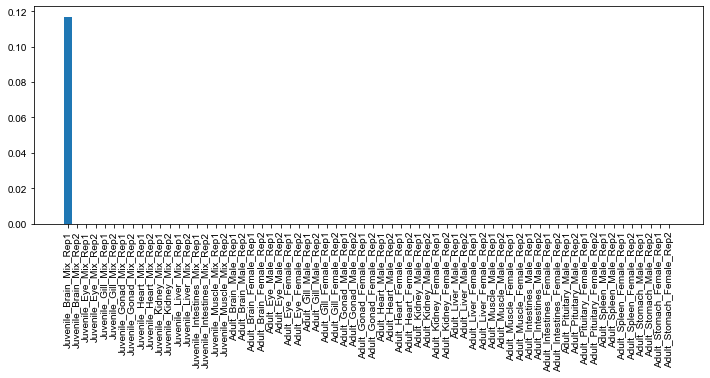

rna-XM_022745163.1


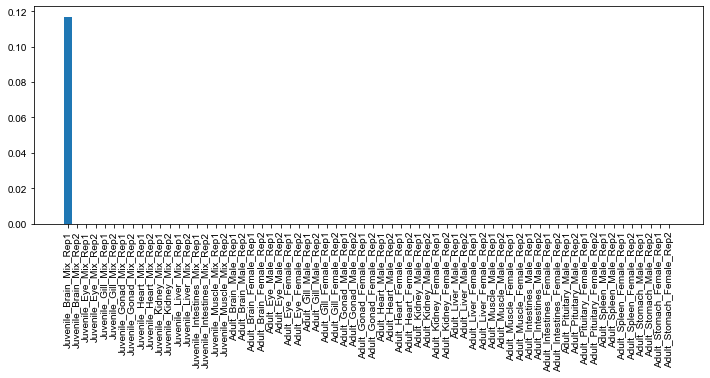

rna-XM_022748152.1


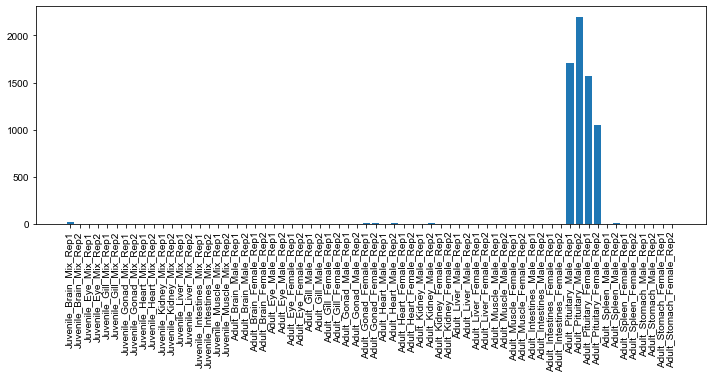

rna-XM_022754356.1


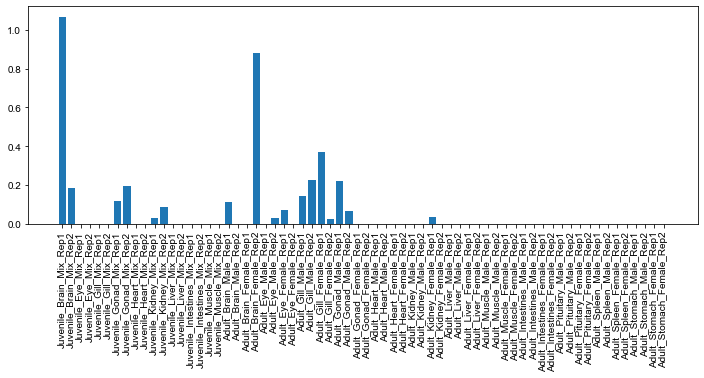

rna-XM_022757304.1


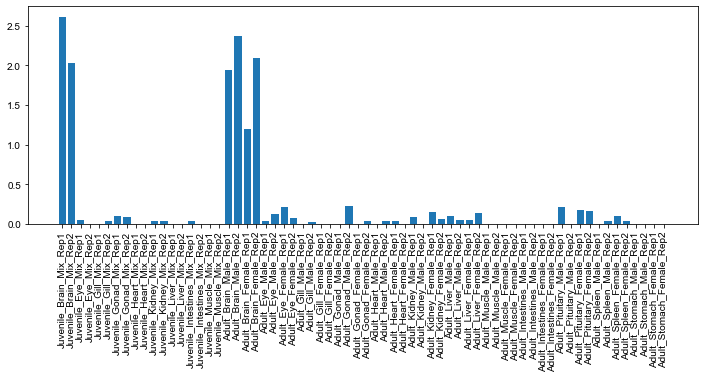

rna-XM_022762004.1


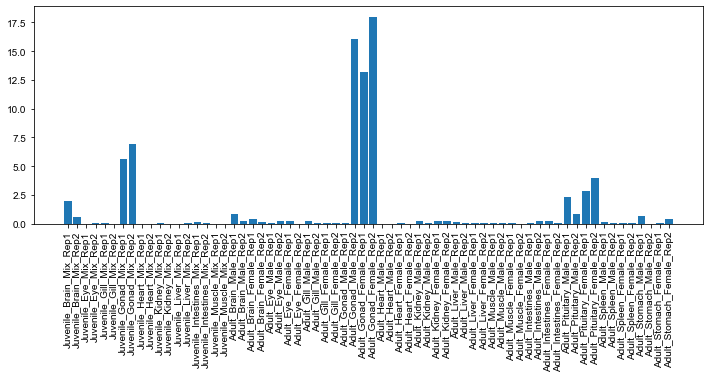

rna-XM_022763660.1


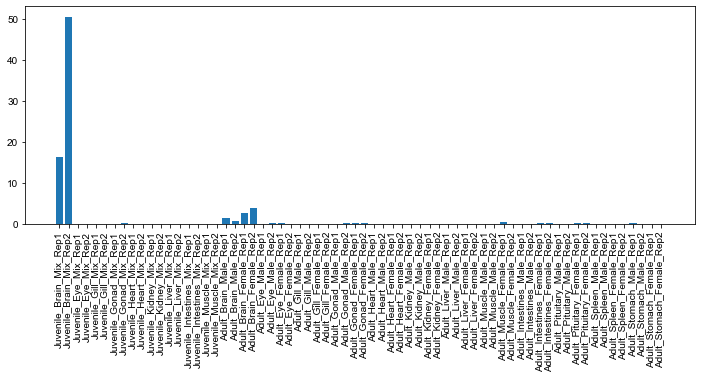

In [90]:
tids = [
    "rna-XM_022740281.1",
    "rna-XM_022741922.1",
    "rna-XM_022748918.1",
    "rna-XM_022756439.1",
    "rna-XM_022756439.1",
    "rna-XM_022743559.1",
    "rna-XM_022743644.1",
    "rna-XM_022743662.1",
    "rna-XM_022743662.1",
    "rna-XM_022745163.1",
    "rna-XM_022745163.1",
    "rna-XM_022748152.1",
    "rna-XM_022754356.1",
    "rna-XM_022757304.1",
    "rna-XM_022762004.1",
    "rna-XM_022763660.1"
]
for tid in tids:
    print(tid)
    ys = dat.loc[tid].values
    xs = np.arange(len(ys))
    plt.figure(figsize=(12, 4))
    plt.bar(xs, ys)
    plt.xticks(xs, dat.columns, rotation=90)
    plt.show()
    plt.close()

In [103]:
ys = dat.loc["rna-XM_022740281.1"]
vs1 = ys[[
    "Adult_Pituitary_Male_Rep1", "Adult_Pituitary_Male_Rep2", 
    "Adult_Pituitary_Female_Rep1", "Adult_Pituitary_Female_Rep2"
]]
vs2 = ys[[
    'Juvenile_Brain_Mix_Rep1', 'Juvenile_Brain_Mix_Rep2',
    'Adult_Brain_Male_Rep1', 'Adult_Brain_Male_Rep2',
    'Adult_Brain_Female_Rep1', 'Adult_Brain_Female_Rep2',
]]
vs3 = ys[[
    'Juvenile_Gonad_Mix_Rep1', 'Juvenile_Gonad_Mix_Rep2',
    'Adult_Gonad_Male_Rep1', 'Adult_Gonad_Male_Rep2',
    'Adult_Gonad_Female_Rep1', 'Adult_Gonad_Female_Rep2',
]]
vs4 = ys[[
    'Juvenile_Eye_Mix_Rep1', 'Juvenile_Eye_Mix_Rep2',
    'Juvenile_Gill_Mix_Rep1', 'Juvenile_Gill_Mix_Rep2',
    'Juvenile_Heart_Mix_Rep1', 'Juvenile_Heart_Mix_Rep2',
    'Juvenile_Kidney_Mix_Rep1', 'Juvenile_Kidney_Mix_Rep2',
    'Juvenile_Liver_Mix_Rep1', 'Juvenile_Liver_Mix_Rep2',
    'Juvenile_Intestines_Mix_Rep1', 'Juvenile_Intestines_Mix_Rep2',
    'Juvenile_Muscle_Mix_Rep1', 'Juvenile_Muscle_Mix_Rep2',
    'Adult_Eye_Male_Rep1', 'Adult_Eye_Male_Rep2', 'Adult_Eye_Female_Rep1',
    'Adult_Eye_Female_Rep2', 'Adult_Gill_Male_Rep1', 'Adult_Gill_Male_Rep2',
    'Adult_Gill_Female_Rep1', 'Adult_Gill_Female_Rep2',
    'Adult_Heart_Male_Rep1', 'Adult_Heart_Male_Rep2',
    'Adult_Heart_Female_Rep1', 'Adult_Heart_Female_Rep2',
    'Adult_Kidney_Male_Rep1', 'Adult_Kidney_Male_Rep2',
    'Adult_Kidney_Female_Rep1', 'Adult_Kidney_Female_Rep2',
    'Adult_Liver_Male_Rep1', 'Adult_Liver_Male_Rep2',
    'Adult_Liver_Female_Rep1', 'Adult_Liver_Female_Rep2',
    'Adult_Muscle_Male_Rep1', 'Adult_Muscle_Male_Rep2',
    'Adult_Muscle_Female_Rep1', 'Adult_Muscle_Female_Rep2',
    'Adult_Intestines_Male_Rep1', 'Adult_Intestines_Male_Rep2',
    'Adult_Intestines_Female_Rep1', 'Adult_Intestines_Female_Rep2',
    'Adult_Spleen_Male_Rep1', 'Adult_Spleen_Male_Rep2',
    'Adult_Spleen_Female_Rep1', 'Adult_Spleen_Female_Rep2',
    'Adult_Stomach_Male_Rep1', 'Adult_Stomach_Male_Rep2',
    'Adult_Stomach_Female_Rep1', 'Adult_Stomach_Female_Rep2'
]]

array = [vs1, vs2, vs3, vs4]
means = [np.mean(vs) for vs in array]
stds = [np.std(vs) for vs in array]
xs = np.arange(len(means))
xticks = ["Pituitary", "Brain", "Gonad", "Other"]

plt.figure(figsize=(3, 3))
plt.bar(xs, means, lw=1, edgecolor="black", color="dodgerblue",
        yerr=stds, error_kw={"capsize": 4, "linewidth": 1})
plt.text(1.5, 50, "$LOC111218147$")
plt.xticks(xs, xticks, rotation=45)
plt.ylim(0, 60)
plt.yticks([0, 10, 20, 30, 40, 50, 60])
plt.ylabel("Expression (FPKM)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/gonad.LOC111218147.png", dpi=300)
plt.close()

In [109]:
ys = dat.loc["rna-XM_022748918.1"]
vs1 = ys[[
    "Adult_Pituitary_Male_Rep1", "Adult_Pituitary_Male_Rep2", 
    "Adult_Pituitary_Female_Rep1", "Adult_Pituitary_Female_Rep2"
]]
vs2 = ys[[
    'Juvenile_Brain_Mix_Rep1', 'Juvenile_Brain_Mix_Rep2',
    'Adult_Brain_Male_Rep1', 'Adult_Brain_Male_Rep2',
    'Adult_Brain_Female_Rep1', 'Adult_Brain_Female_Rep2',
]]
vs3 = ys[[
    'Juvenile_Gonad_Mix_Rep1', 'Juvenile_Gonad_Mix_Rep2',
    'Adult_Gonad_Male_Rep1', 'Adult_Gonad_Male_Rep2',
    'Adult_Gonad_Female_Rep1', 'Adult_Gonad_Female_Rep2',
]]
vs4 = ys[[
    'Juvenile_Eye_Mix_Rep1', 'Juvenile_Eye_Mix_Rep2',
    'Juvenile_Gill_Mix_Rep1', 'Juvenile_Gill_Mix_Rep2',
    'Juvenile_Heart_Mix_Rep1', 'Juvenile_Heart_Mix_Rep2',
    'Juvenile_Kidney_Mix_Rep1', 'Juvenile_Kidney_Mix_Rep2',
    'Juvenile_Liver_Mix_Rep1', 'Juvenile_Liver_Mix_Rep2',
    'Juvenile_Intestines_Mix_Rep1', 'Juvenile_Intestines_Mix_Rep2',
    'Juvenile_Muscle_Mix_Rep1', 'Juvenile_Muscle_Mix_Rep2',
    'Adult_Eye_Male_Rep1', 'Adult_Eye_Male_Rep2', 'Adult_Eye_Female_Rep1',
    'Adult_Eye_Female_Rep2', 'Adult_Gill_Male_Rep1', 'Adult_Gill_Male_Rep2',
    'Adult_Gill_Female_Rep1', 'Adult_Gill_Female_Rep2',
    'Adult_Heart_Male_Rep1', 'Adult_Heart_Male_Rep2',
    'Adult_Heart_Female_Rep1', 'Adult_Heart_Female_Rep2',
    'Adult_Kidney_Male_Rep1', 'Adult_Kidney_Male_Rep2',
    'Adult_Kidney_Female_Rep1', 'Adult_Kidney_Female_Rep2',
    'Adult_Liver_Male_Rep1', 'Adult_Liver_Male_Rep2',
    'Adult_Liver_Female_Rep1', 'Adult_Liver_Female_Rep2',
    'Adult_Muscle_Male_Rep1', 'Adult_Muscle_Male_Rep2',
    'Adult_Muscle_Female_Rep1', 'Adult_Muscle_Female_Rep2',
    'Adult_Intestines_Male_Rep1', 'Adult_Intestines_Male_Rep2',
    'Adult_Intestines_Female_Rep1', 'Adult_Intestines_Female_Rep2',
    'Adult_Spleen_Male_Rep1', 'Adult_Spleen_Male_Rep2',
    'Adult_Spleen_Female_Rep1', 'Adult_Spleen_Female_Rep2',
    'Adult_Stomach_Male_Rep1', 'Adult_Stomach_Male_Rep2',
    'Adult_Stomach_Female_Rep1', 'Adult_Stomach_Female_Rep2'
]]

array = [vs1, vs2, vs3, vs4]
means = [np.mean(vs) for vs in array]
stds = [np.std(vs) for vs in array]
xs = np.arange(len(means))
xticks = ["Pituitary", "Brain", "Gonad", "Other"]

plt.figure(figsize=(3, 3))
plt.bar(xs, means, lw=1, edgecolor="black", color="dodgerblue",
        yerr=stds, error_kw={"capsize": 4, "linewidth": 1})
plt.text(1.5, 1900, "$LOC111224431$")
plt.xticks(xs, xticks, rotation=45)
plt.ylim(0, 2000)
#plt.yticks([0, 10, 20, 30, 40, 50, 60])
plt.ylabel("Expression (FPKM)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/gonad.LOC111224431.png", dpi=300)
plt.close()

In [115]:
ys = dat.loc["rna-XM_022748152.1"]
vs1 = ys[[
    "Adult_Pituitary_Male_Rep1", "Adult_Pituitary_Male_Rep2", 
    "Adult_Pituitary_Female_Rep1", "Adult_Pituitary_Female_Rep2"
]]
vs2 = ys[[
    'Juvenile_Brain_Mix_Rep1', 'Juvenile_Brain_Mix_Rep2',
    'Adult_Brain_Male_Rep1', 'Adult_Brain_Male_Rep2',
    'Adult_Brain_Female_Rep1', 'Adult_Brain_Female_Rep2',
]]
vs3 = ys[[
    'Juvenile_Gonad_Mix_Rep1', 'Juvenile_Gonad_Mix_Rep2',
    'Adult_Gonad_Male_Rep1', 'Adult_Gonad_Male_Rep2',
    'Adult_Gonad_Female_Rep1', 'Adult_Gonad_Female_Rep2',
]]
vs4 = ys[[
    'Juvenile_Eye_Mix_Rep1', 'Juvenile_Eye_Mix_Rep2',
    'Juvenile_Gill_Mix_Rep1', 'Juvenile_Gill_Mix_Rep2',
    'Juvenile_Heart_Mix_Rep1', 'Juvenile_Heart_Mix_Rep2',
    'Juvenile_Kidney_Mix_Rep1', 'Juvenile_Kidney_Mix_Rep2',
    'Juvenile_Liver_Mix_Rep1', 'Juvenile_Liver_Mix_Rep2',
    'Juvenile_Intestines_Mix_Rep1', 'Juvenile_Intestines_Mix_Rep2',
    'Juvenile_Muscle_Mix_Rep1', 'Juvenile_Muscle_Mix_Rep2',
    'Adult_Eye_Male_Rep1', 'Adult_Eye_Male_Rep2', 'Adult_Eye_Female_Rep1',
    'Adult_Eye_Female_Rep2', 'Adult_Gill_Male_Rep1', 'Adult_Gill_Male_Rep2',
    'Adult_Gill_Female_Rep1', 'Adult_Gill_Female_Rep2',
    'Adult_Heart_Male_Rep1', 'Adult_Heart_Male_Rep2',
    'Adult_Heart_Female_Rep1', 'Adult_Heart_Female_Rep2',
    'Adult_Kidney_Male_Rep1', 'Adult_Kidney_Male_Rep2',
    'Adult_Kidney_Female_Rep1', 'Adult_Kidney_Female_Rep2',
    'Adult_Liver_Male_Rep1', 'Adult_Liver_Male_Rep2',
    'Adult_Liver_Female_Rep1', 'Adult_Liver_Female_Rep2',
    'Adult_Muscle_Male_Rep1', 'Adult_Muscle_Male_Rep2',
    'Adult_Muscle_Female_Rep1', 'Adult_Muscle_Female_Rep2',
    'Adult_Intestines_Male_Rep1', 'Adult_Intestines_Male_Rep2',
    'Adult_Intestines_Female_Rep1', 'Adult_Intestines_Female_Rep2',
    'Adult_Spleen_Male_Rep1', 'Adult_Spleen_Male_Rep2',
    'Adult_Spleen_Female_Rep1', 'Adult_Spleen_Female_Rep2',
    'Adult_Stomach_Male_Rep1', 'Adult_Stomach_Male_Rep2',
    'Adult_Stomach_Female_Rep1', 'Adult_Stomach_Female_Rep2'
]]

array = [vs1, vs2, vs3, vs4]
means = [np.mean(vs) for vs in array]
stds = [np.std(vs) for vs in array]
xs = np.arange(len(means))
xticks = ["Pituitary", "Brain", "Gonad", "Other"]

plt.figure(figsize=(3, 3))
plt.bar(xs, means, lw=1, edgecolor="black", color="dodgerblue",
        yerr=stds, error_kw={"capsize": 4, "linewidth": 1})
plt.text(1.5, 2300, "$LOC111223861$")
plt.xticks(xs, xticks, rotation=45)
plt.ylim(0, 2500)
#plt.yticks([0, 10, 20, 30, 40, 50, 60])
plt.ylabel("Expression (FPKM)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/gonad.LOC111223861.png", dpi=300)
plt.close()

In [122]:
ys = dat.loc["rna-XM_022743559.1"]
vs1 = ys[[
    "Adult_Pituitary_Male_Rep1", "Adult_Pituitary_Male_Rep2", 
    "Adult_Pituitary_Female_Rep1", "Adult_Pituitary_Female_Rep2"
]]
vs2 = ys[[
    'Juvenile_Brain_Mix_Rep1', 'Juvenile_Brain_Mix_Rep2',
    'Adult_Brain_Male_Rep1', 'Adult_Brain_Male_Rep2',
    'Adult_Brain_Female_Rep1', 'Adult_Brain_Female_Rep2',
]]
vs3 = ys[[
    'Juvenile_Gonad_Mix_Rep1', 'Juvenile_Gonad_Mix_Rep2',
]]
vs4 = ys[[
    'Adult_Gonad_Male_Rep1', 'Adult_Gonad_Male_Rep2',
    'Adult_Gonad_Female_Rep1', 'Adult_Gonad_Female_Rep2',
]]
vs5 = ys[[
    'Juvenile_Eye_Mix_Rep1', 'Juvenile_Eye_Mix_Rep2',
    'Juvenile_Gill_Mix_Rep1', 'Juvenile_Gill_Mix_Rep2',
    'Juvenile_Heart_Mix_Rep1', 'Juvenile_Heart_Mix_Rep2',
    'Juvenile_Kidney_Mix_Rep1', 'Juvenile_Kidney_Mix_Rep2',
    'Juvenile_Liver_Mix_Rep1', 'Juvenile_Liver_Mix_Rep2',
    'Juvenile_Intestines_Mix_Rep1', 'Juvenile_Intestines_Mix_Rep2',
    'Juvenile_Muscle_Mix_Rep1', 'Juvenile_Muscle_Mix_Rep2',
    'Adult_Eye_Male_Rep1', 'Adult_Eye_Male_Rep2', 'Adult_Eye_Female_Rep1',
    'Adult_Eye_Female_Rep2', 'Adult_Gill_Male_Rep1', 'Adult_Gill_Male_Rep2',
    'Adult_Gill_Female_Rep1', 'Adult_Gill_Female_Rep2',
    'Adult_Heart_Male_Rep1', 'Adult_Heart_Male_Rep2',
    'Adult_Heart_Female_Rep1', 'Adult_Heart_Female_Rep2',
    'Adult_Kidney_Male_Rep1', 'Adult_Kidney_Male_Rep2',
    'Adult_Kidney_Female_Rep1', 'Adult_Kidney_Female_Rep2',
    'Adult_Liver_Male_Rep1', 'Adult_Liver_Male_Rep2',
    'Adult_Liver_Female_Rep1', 'Adult_Liver_Female_Rep2',
    'Adult_Muscle_Male_Rep1', 'Adult_Muscle_Male_Rep2',
    'Adult_Muscle_Female_Rep1', 'Adult_Muscle_Female_Rep2',
    'Adult_Intestines_Male_Rep1', 'Adult_Intestines_Male_Rep2',
    'Adult_Intestines_Female_Rep1', 'Adult_Intestines_Female_Rep2',
    'Adult_Spleen_Male_Rep1', 'Adult_Spleen_Male_Rep2',
    'Adult_Spleen_Female_Rep1', 'Adult_Spleen_Female_Rep2',
    'Adult_Stomach_Male_Rep1', 'Adult_Stomach_Male_Rep2',
    'Adult_Stomach_Female_Rep1', 'Adult_Stomach_Female_Rep2'
]]

array = [vs1, vs2, vs3, vs4, vs5]
means = [np.mean(vs) for vs in array]
stds = [np.std(vs) for vs in array]
xs = np.arange(len(means))
xticks = ["Pituitary", "Brain", "Gonad (J)", "Gonad (A)", "Other"]

plt.figure(figsize=(3, 3))
plt.bar(xs, means, lw=1, edgecolor="black", color="dodgerblue",
        yerr=stds, error_kw={"capsize": 4, "linewidth": 1})
# plt.text(1.5, 180, "$LOC111220462$")
plt.xticks(xs, xticks, rotation=45)
plt.ylim(0, 200)
#plt.yticks([0, 10, 20, 30, 40, 50, 60])
plt.ylabel("Expression (FPKM)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/gonad.LOC111220462.png", dpi=300)
plt.close()

In [126]:
ys = dat.loc["rna-XM_022763660.1"]
vs1 = ys[[
    "Adult_Pituitary_Male_Rep1", "Adult_Pituitary_Male_Rep2", 
    "Adult_Pituitary_Female_Rep1", "Adult_Pituitary_Female_Rep2"
]]
vs2 = ys[[
    'Juvenile_Brain_Mix_Rep1', 'Juvenile_Brain_Mix_Rep2',
]]
vs3 = ys[[
    'Adult_Brain_Male_Rep1', 'Adult_Brain_Male_Rep2',
    'Adult_Brain_Female_Rep1', 'Adult_Brain_Female_Rep2',
]]
vs4 = ys[[
    'Juvenile_Gonad_Mix_Rep1', 'Juvenile_Gonad_Mix_Rep2',
    'Adult_Gonad_Male_Rep1', 'Adult_Gonad_Male_Rep2',
    'Adult_Gonad_Female_Rep1', 'Adult_Gonad_Female_Rep2',
]]
vs5 = ys[[
    'Juvenile_Eye_Mix_Rep1', 'Juvenile_Eye_Mix_Rep2',
    'Juvenile_Gill_Mix_Rep1', 'Juvenile_Gill_Mix_Rep2',
    'Juvenile_Heart_Mix_Rep1', 'Juvenile_Heart_Mix_Rep2',
    'Juvenile_Kidney_Mix_Rep1', 'Juvenile_Kidney_Mix_Rep2',
    'Juvenile_Liver_Mix_Rep1', 'Juvenile_Liver_Mix_Rep2',
    'Juvenile_Intestines_Mix_Rep1', 'Juvenile_Intestines_Mix_Rep2',
    'Juvenile_Muscle_Mix_Rep1', 'Juvenile_Muscle_Mix_Rep2',
    'Adult_Eye_Male_Rep1', 'Adult_Eye_Male_Rep2', 'Adult_Eye_Female_Rep1',
    'Adult_Eye_Female_Rep2', 'Adult_Gill_Male_Rep1', 'Adult_Gill_Male_Rep2',
    'Adult_Gill_Female_Rep1', 'Adult_Gill_Female_Rep2',
    'Adult_Heart_Male_Rep1', 'Adult_Heart_Male_Rep2',
    'Adult_Heart_Female_Rep1', 'Adult_Heart_Female_Rep2',
    'Adult_Kidney_Male_Rep1', 'Adult_Kidney_Male_Rep2',
    'Adult_Kidney_Female_Rep1', 'Adult_Kidney_Female_Rep2',
    'Adult_Liver_Male_Rep1', 'Adult_Liver_Male_Rep2',
    'Adult_Liver_Female_Rep1', 'Adult_Liver_Female_Rep2',
    'Adult_Muscle_Male_Rep1', 'Adult_Muscle_Male_Rep2',
    'Adult_Muscle_Female_Rep1', 'Adult_Muscle_Female_Rep2',
    'Adult_Intestines_Male_Rep1', 'Adult_Intestines_Male_Rep2',
    'Adult_Intestines_Female_Rep1', 'Adult_Intestines_Female_Rep2',
    'Adult_Spleen_Male_Rep1', 'Adult_Spleen_Male_Rep2',
    'Adult_Spleen_Female_Rep1', 'Adult_Spleen_Female_Rep2',
    'Adult_Stomach_Male_Rep1', 'Adult_Stomach_Male_Rep2',
    'Adult_Stomach_Female_Rep1', 'Adult_Stomach_Female_Rep2'
]]

array = [vs1, vs2, vs3, vs4, vs5]
means = [np.mean(vs) for vs in array]
stds = [np.std(vs) for vs in array]
xs = np.arange(len(means))
xticks = ["Pituitary", "Brain (J)", "Brain (A)", "Gonad", "Other"]

plt.figure(figsize=(3, 3))
plt.bar(xs, means, lw=1, edgecolor="black", color="dodgerblue",
        yerr=stds, error_kw={"capsize": 4, "linewidth": 1})
# plt.text(1.5, 180, "$LOC111235260$")
plt.xticks(xs, xticks, rotation=45)
plt.ylim(0, 60)
#plt.yticks([0, 10, 20, 30, 40, 50, 60])
plt.ylabel("Expression (FPKM)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/gonad.LOC111235260.png", dpi=300)
plt.close()

In [47]:
tmp = ret.data2d

In [49]:
columns = [
    "Adult_Gonad_Male_Rep1", "Adult_Gonad_Male_Rep2", 
    "Adult_Gonad_Female_Rep1", "Adult_Gonad_Female_Rep2", 
    "Juvenile_Gonad_Mix_Rep1", "Juvenile_Gonad_Mix_Rep2"
]
flags = []
for values, vmax in zip(tmp[columns].values, tmp.max(axis=1)):
    flags.append(max(values) > 0.99 * vmax)
dat3 = dat2.loc[tmp[flags].index]
len(dat3)

5012

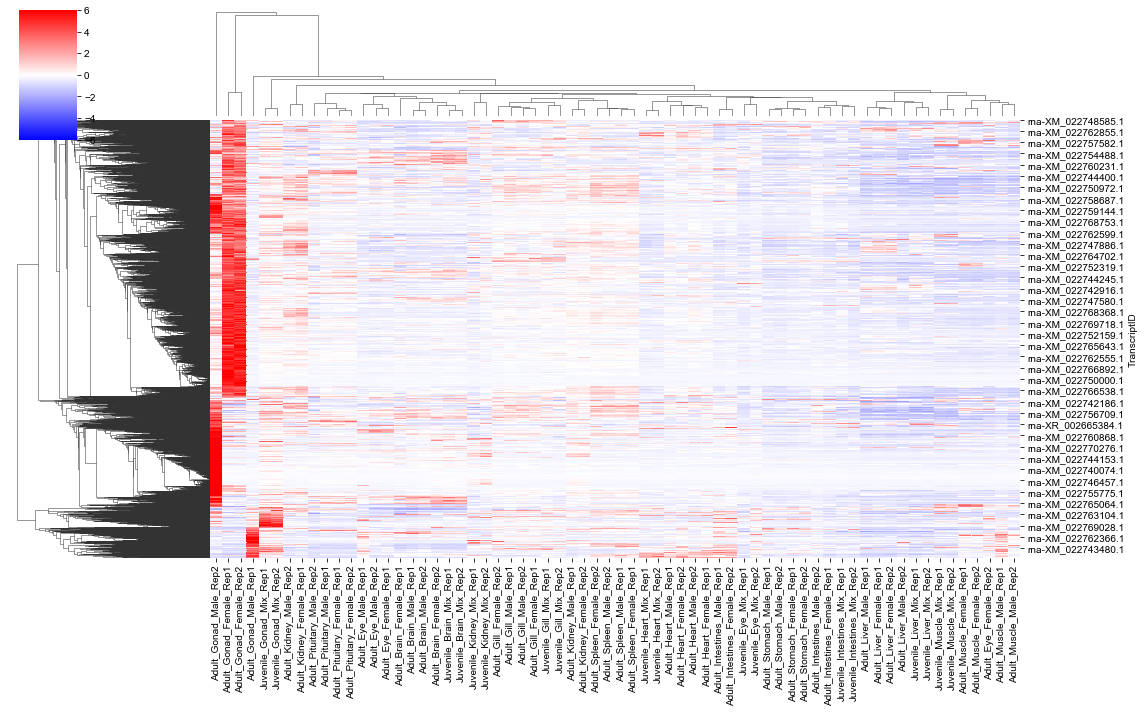

In [55]:
ret = seaborn.clustermap(dat3, z_score=0, cmap="bwr", figsize=(16, 10), xticklabels=True, vmin=-6, vmax=6)

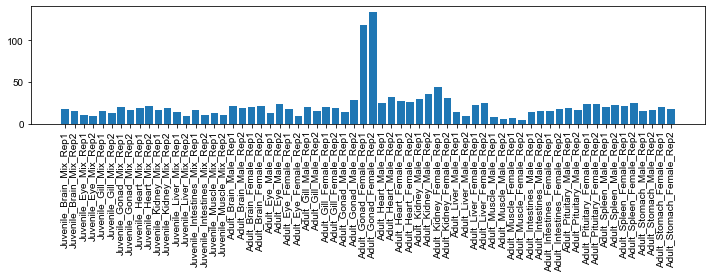

In [61]:
tid = "rna-XM_022768368.1"
ys = dat.loc[tid]
xs = np.arange(len(ys))
plt.figure(figsize=(10, 4))
plt.bar(xs, ys)
plt.xticks(xs, dat.columns, rotation=90)
plt.tight_layout()
plt.show()
plt.close()

In [22]:
dat3 = dat2[["GTS-GN-10-2A", "GTS-GN-11-2A", "GTS-GN-13-2A", "GTS-GN-14-2A", "GN2A", "GN3A"]]
dat3 = dat3[dat3.max(axis=1) > 10]

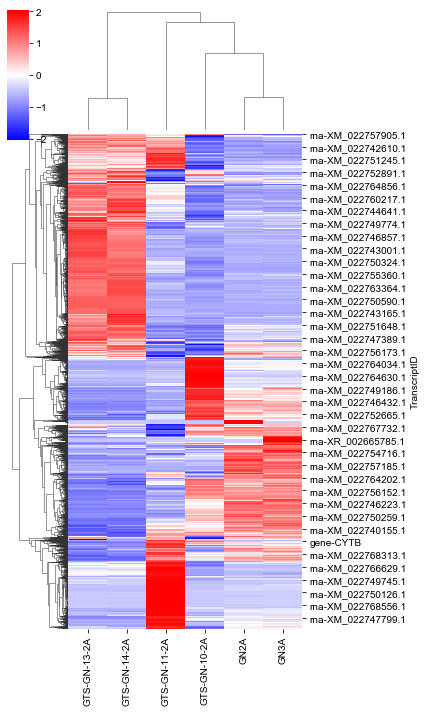

In [25]:
ret = seaborn.clustermap(dat3, z_score=0, cmap="bwr", figsize=(6, 10))

In [198]:
ret.fig.savefig("figures/cluster.genes.gonad.png", dpi=300)

In [242]:
ys = dat3.loc["LOC111227985"]
xs = np.arange(len(ys))
colors = ["dodgerblue", "dodgerblue", "orange", "orange"]

plt.figure(figsize=(3, 3))
plt.bar(xs, ys, edgecolor="black", color=colors)
plt.xticks(xs, ["Testis-1", "Testis-2", "Ovary-1", "Ovary-2"], rotation=45)
plt.ylim(0, 20)
plt.ylabel("Expression level (FPKM)")
plt.text(2, 15, "$\it{dmrt1}$", size=16)
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/dmrt1.png", dpi=300)
plt.close()

In [241]:
ys = dat3.loc["nabp1"]

plt.figure(figsize=(3, 3))
plt.bar(xs, ys, edgecolor="black", color=colors)
plt.xticks(xs, ["Testis-1", "Testis-2", "Ovary-1", "Ovary-2"], rotation=45)
plt.ylim(0, 150)
plt.ylabel("Expression level (FPKM)")
plt.text(0, 130, "$\it{nabp1}$", size=16)
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/nabp1.png", dpi=300)
plt.close()

In [ ]:
# Report Summary

# Genome length

In [17]:
dat = pd.read_csv("data/genome/genome.sizes", sep="\t", header=None)
dat.columns = ["Chrom", "Length"]
dat = dat.sort_values(by="Length")
dat = dat.tail(10)

In [21]:
ticks = dat["Chrom"]
xs = dat["Length"] / 1000000
ys = np.arange(len(xs))
plt.figure(figsize=(4, 3))
plt.barh(ys, xs, color="orange", edgecolor="black", lw=1)
plt.xlim(0, 30)
plt.xlabel("Length (Mb)")
plt.ylim(-0.5, len(ys) - 0.5)
plt.yticks(ys, ticks)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("data/genome/genome.sizes.png", dpi=300)
plt.close()

# 眼睛

In [13]:
dat = pd.read_csv("results/expression/fpkm/combined.annotated.tsv", sep="\t", index_col=0)
dat = dat[dat["Longest"] & (dat["BioType"] == "protein_coding")]

In [67]:
dat1 = dat[dat.columns[:-9]]
dat1 = dat1[dat1.max(axis=1) > 10]

In [68]:
mean = dat1.mean(axis=1)
std = dat1.std(axis=1)

In [69]:
tmp = dat1.subtract(mean, axis=0)
tmp = tmp.divide(std, axis=0)
cols1 = [
    "Juvenile_Eye_Mix_Rep1", "Juvenile_Eye_Mix_Rep2",
    "Adult_Eye_Male_Rep1", "Adult_Eye_Male_Rep2",
    "Adult_Eye_Female_Rep1"
]
cols2 = list(set(tmp.columns) - set(cols1))
tmp1 = tmp[cols1]
tmp2 = tmp[cols2]
tmp3 = tmp[(tmp1.max(axis=1) >=2) & (tmp2.max(axis=1) < 1)]

In [70]:
dat2 = dat1.loc[tmp3.index]
len(dat2)

452

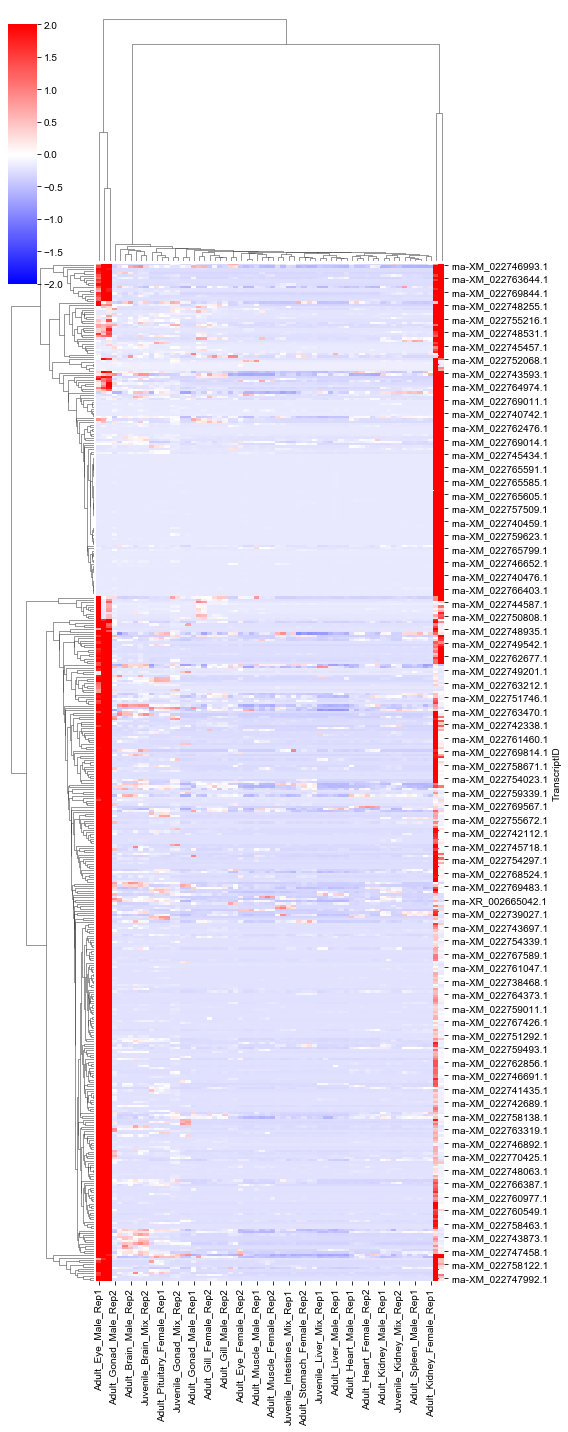

In [71]:
ret = seaborn.clustermap(dat2, z_score=0, cmap="bwr", figsize=(8, 20), vmin=-2, vmax=2)

In [126]:
# gorup1 Common
# group2 Juvenile only
# group3 Adult only

group1 = tmp[(tmp[cols1].min(axis=1) >= 1) & (tmp[cols2].max(axis=1) < 0)].index

c1 = ["Juvenile_Eye_Mix_Rep1", "Juvenile_Eye_Mix_Rep2"]
c2 = list(set(tmp.columns) - set(c1))
group2 = tmp[(tmp[c1].min(axis=1) >= 1) & (tmp[c2].max(axis=1) < 0)].index

c1 = ["Adult_Eye_Male_Rep1", "Adult_Eye_Male_Rep2", "Adult_Eye_Female_Rep1"]
c2 = list(set(tmp.columns) - set(c1))
group3 = tmp[(tmp[c1].min(axis=1) >= 1) & (tmp[c2].max(axis=1) < 0)].index

print(len(group1), len(group2), len(group3))

18 71 6


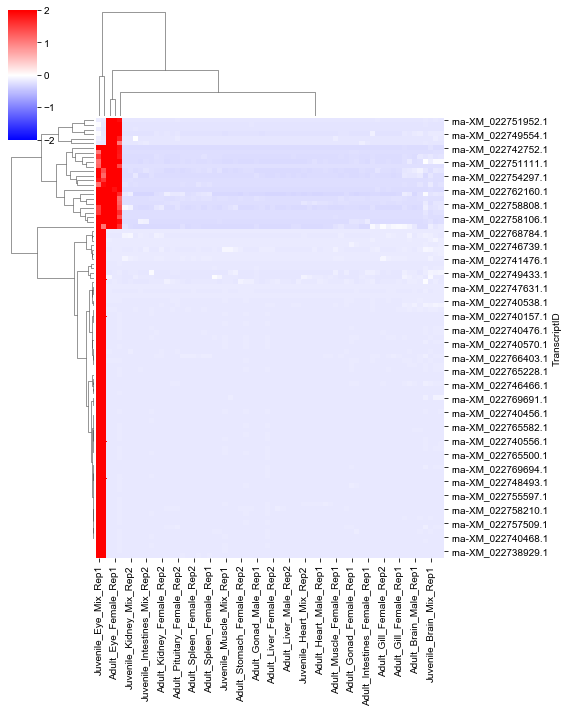

In [124]:
dat3 = dat1.loc[group1 | group2 | group3]
ret = seaborn.clustermap(dat3, z_score=0, cmap="bwr", figsize=(8, 10), vmin=-2, vmax=2)

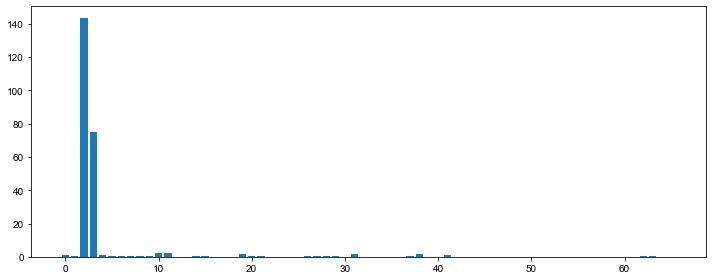

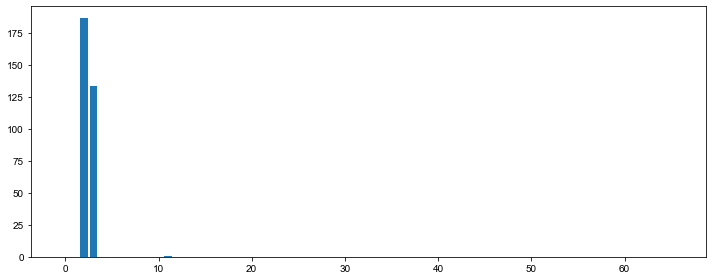

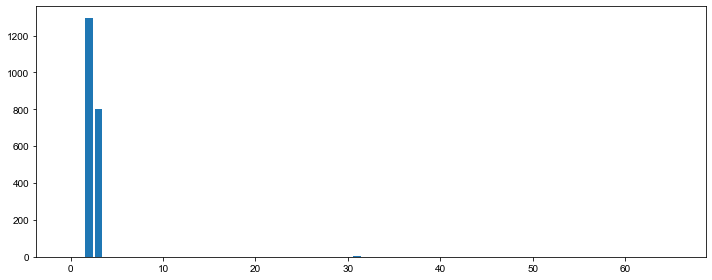

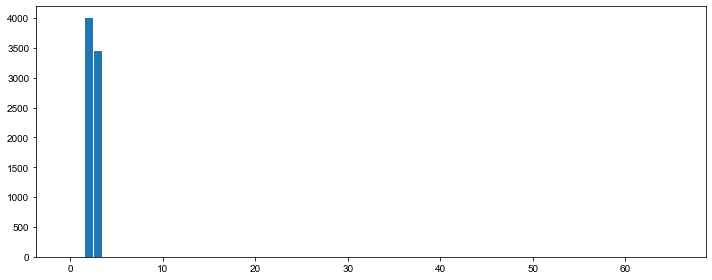

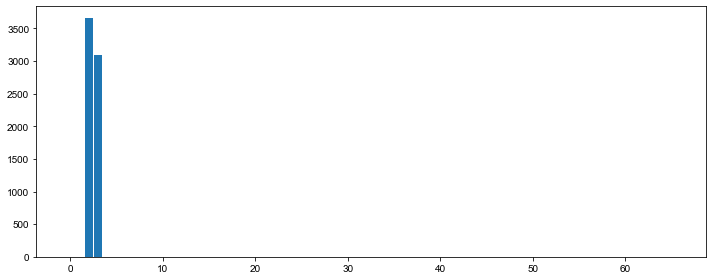

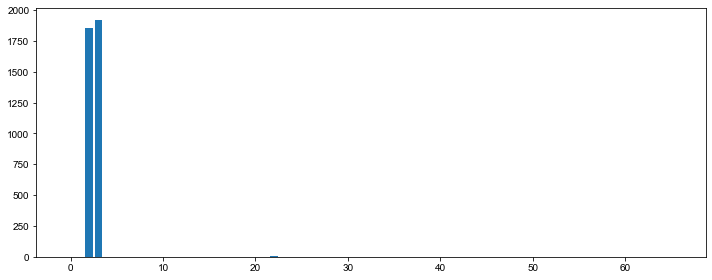

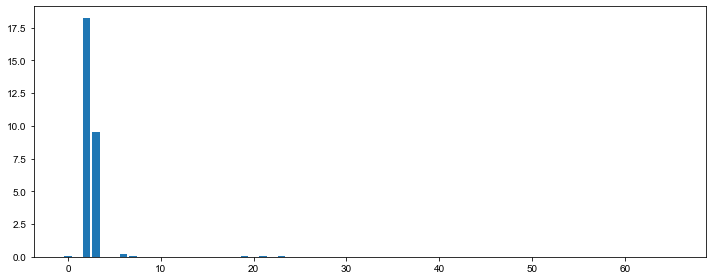

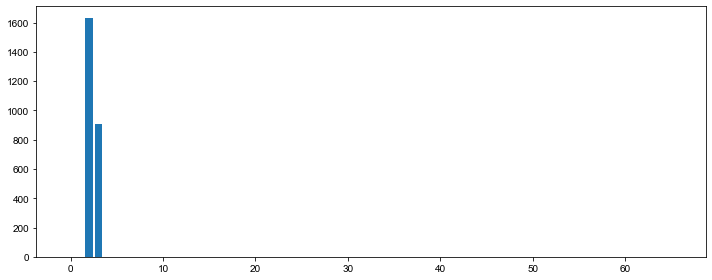

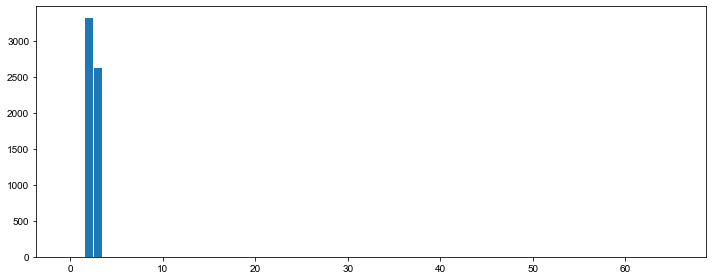

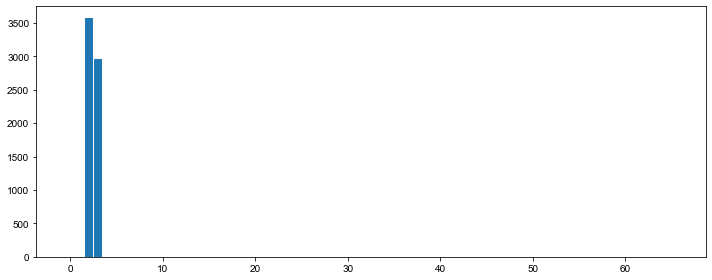

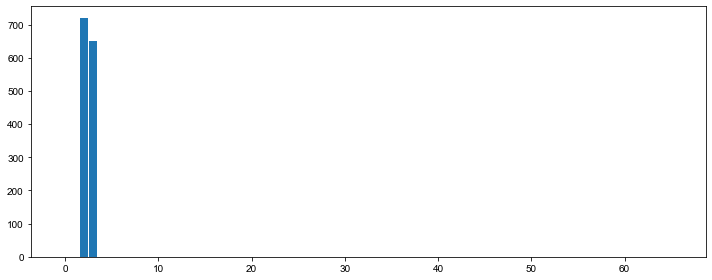

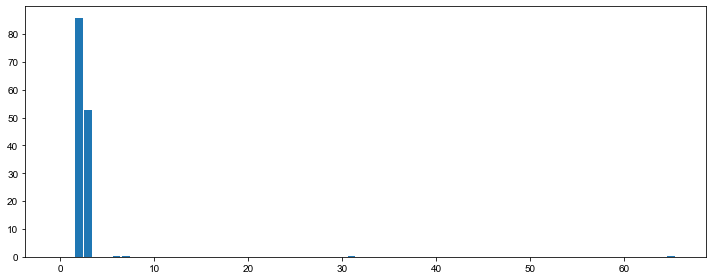

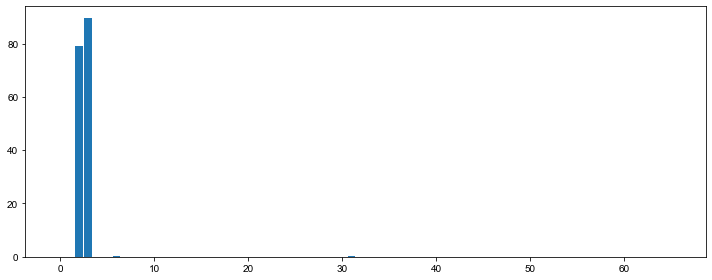

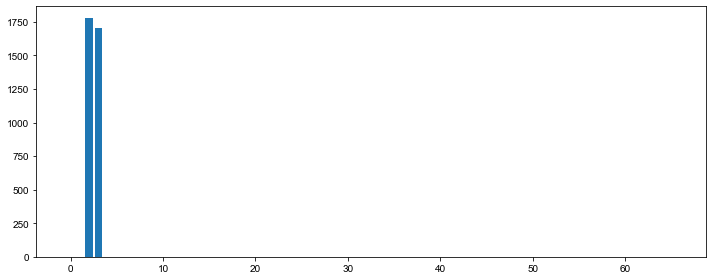

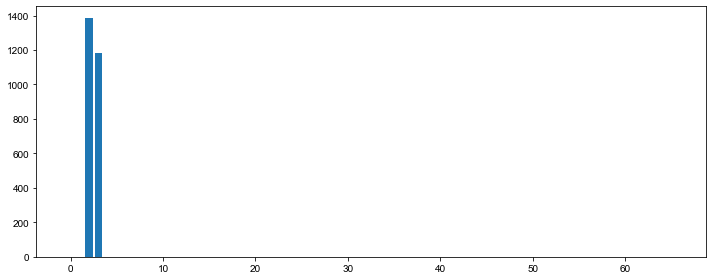

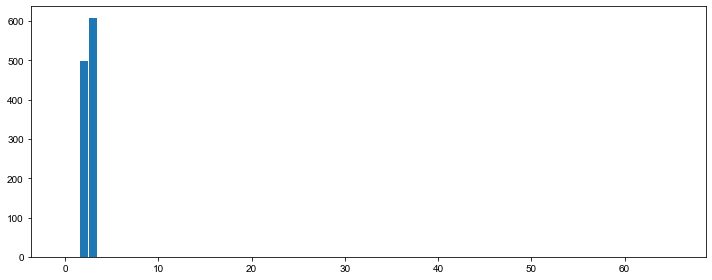

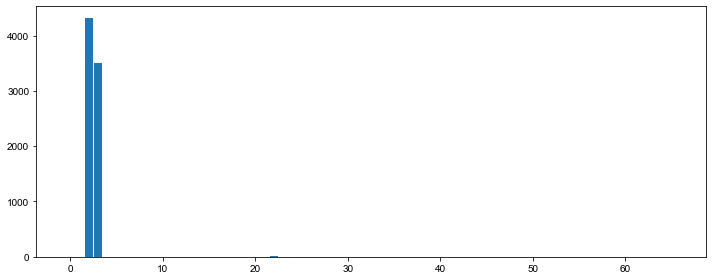

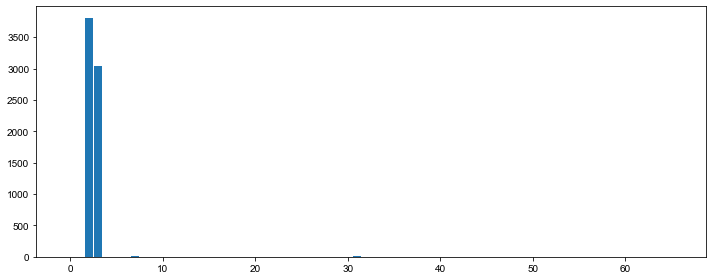

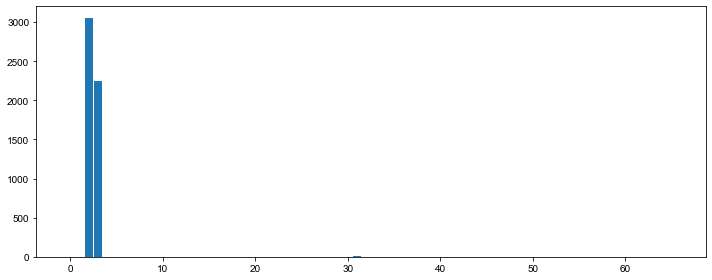

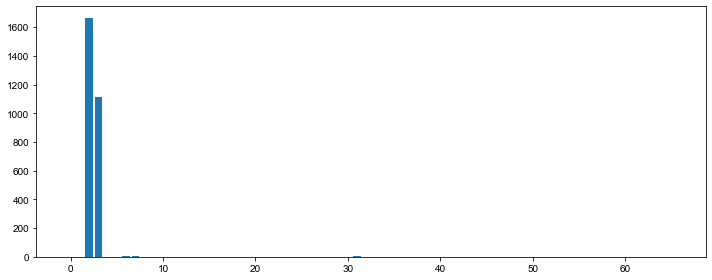

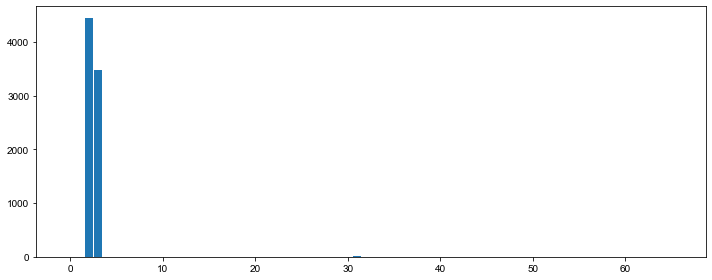

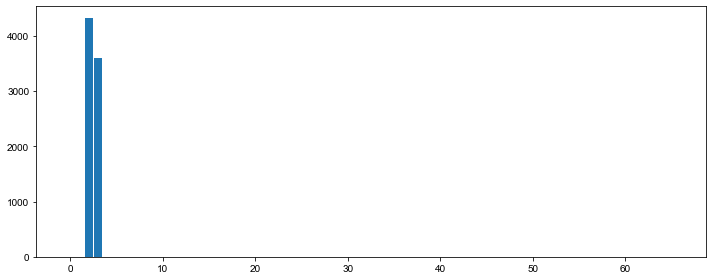

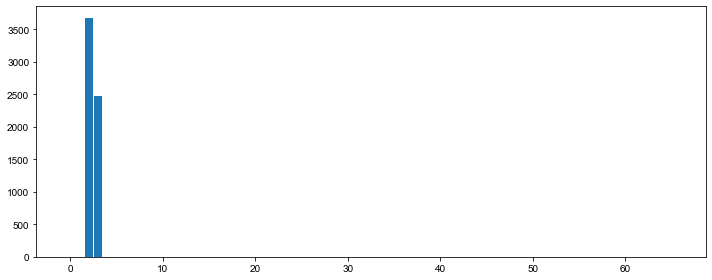

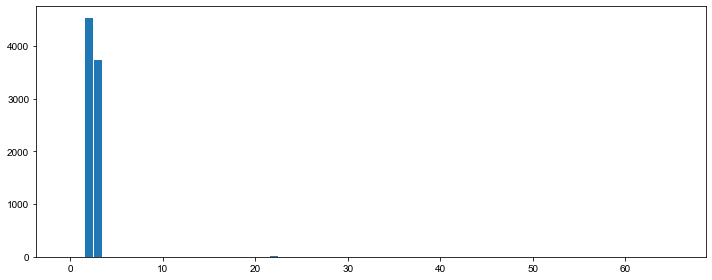

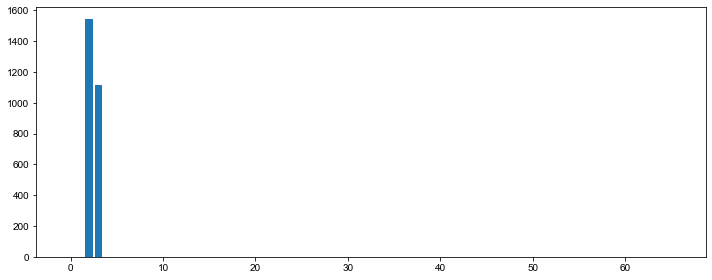

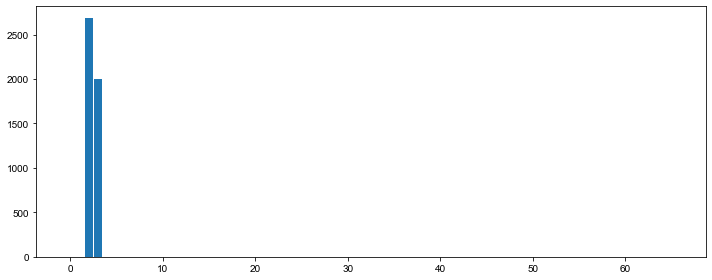

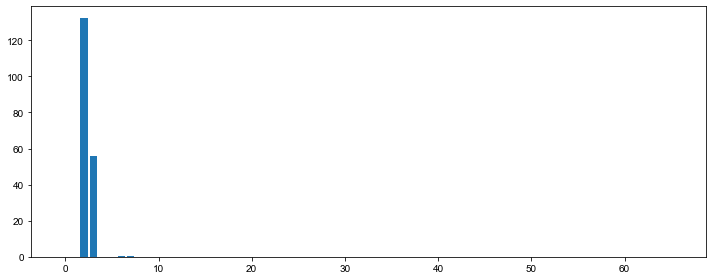

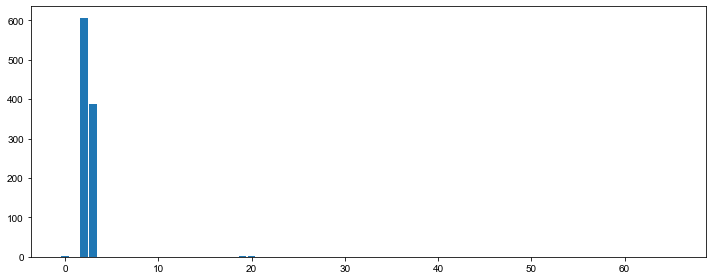

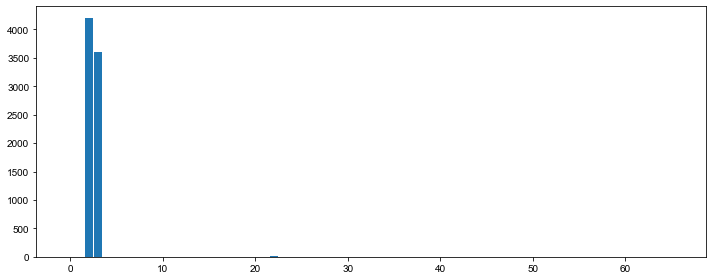

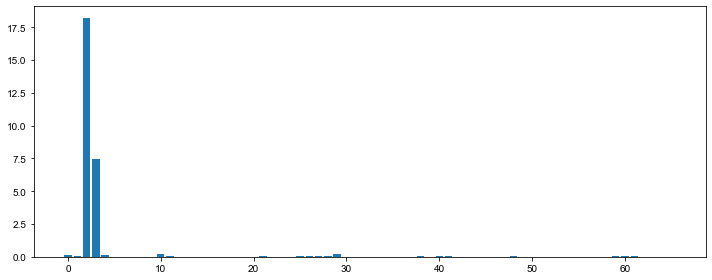

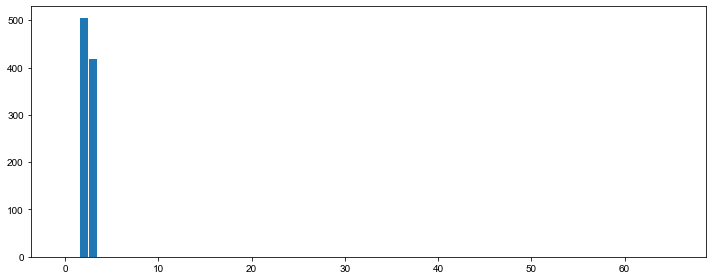

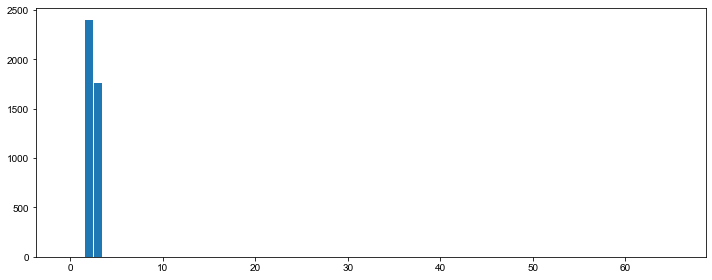

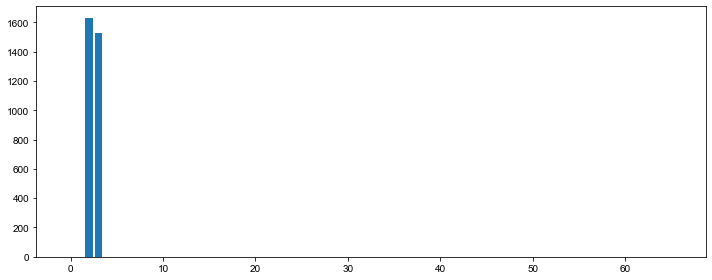

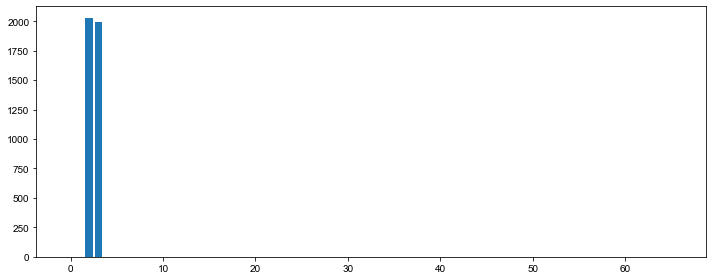

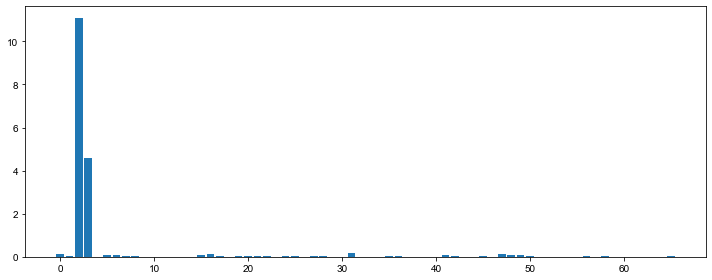

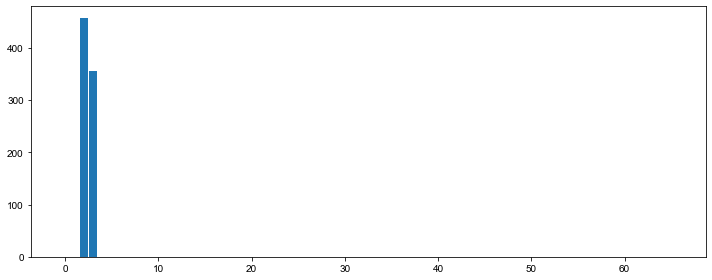

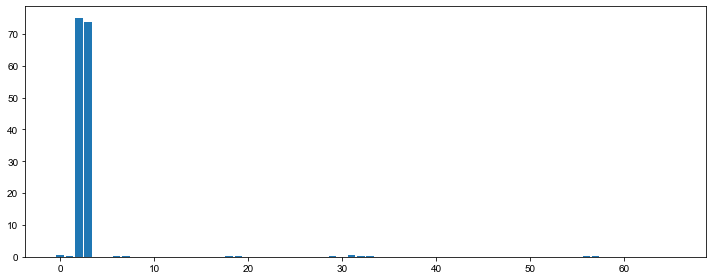

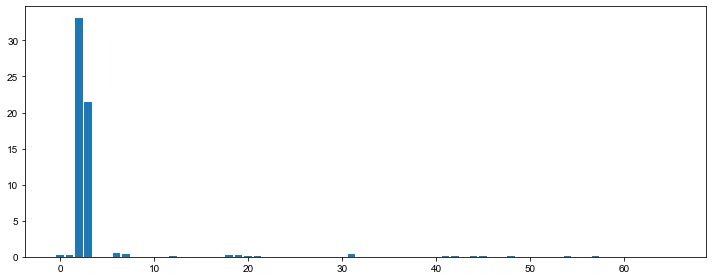

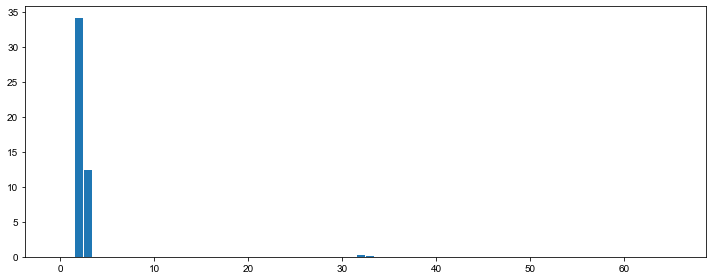

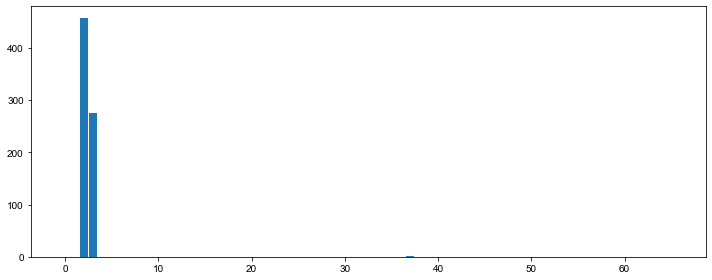

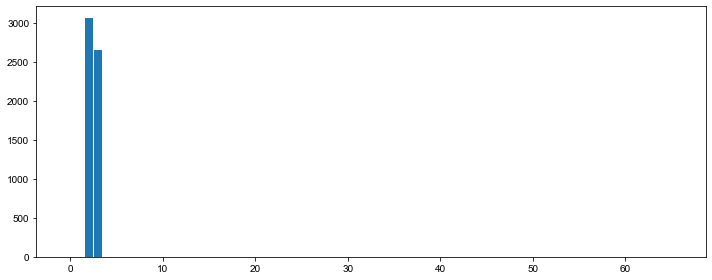

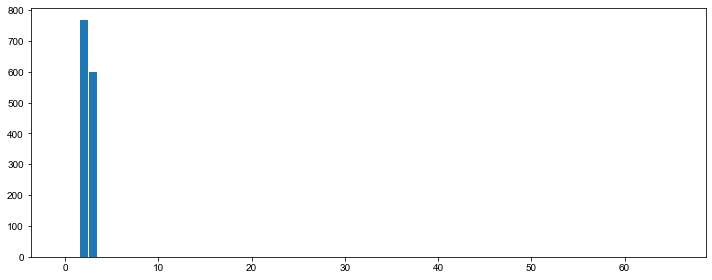

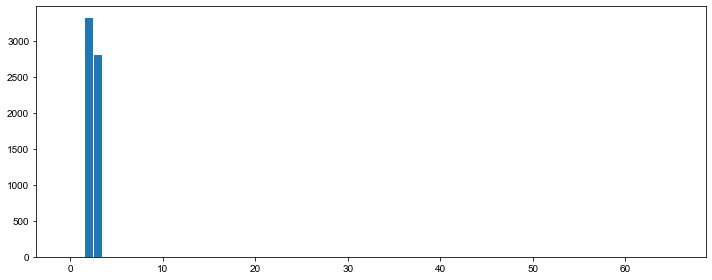

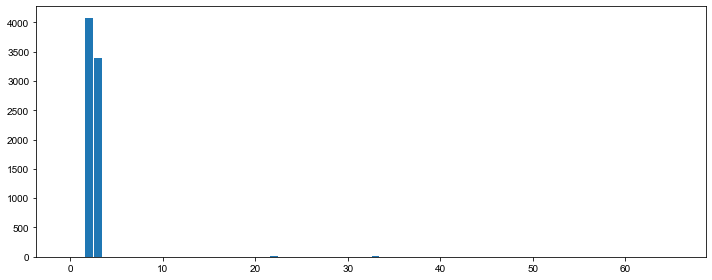

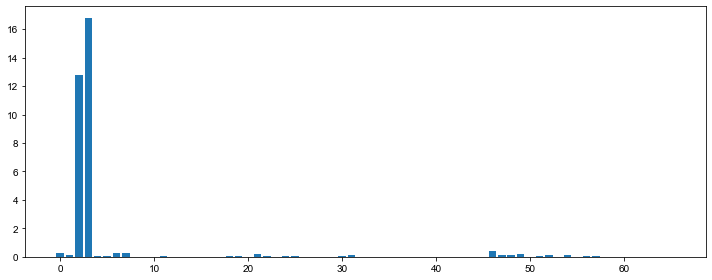

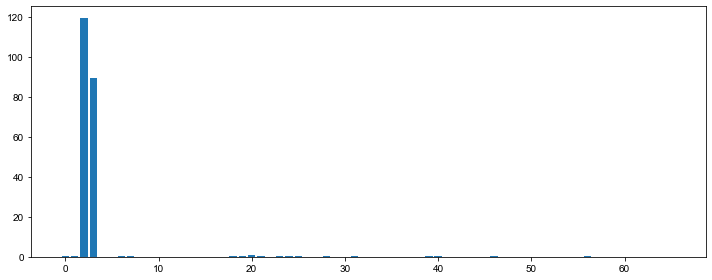

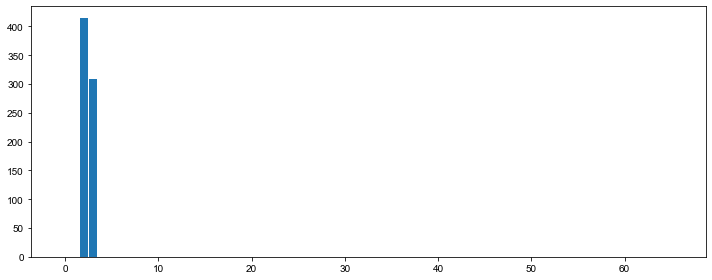

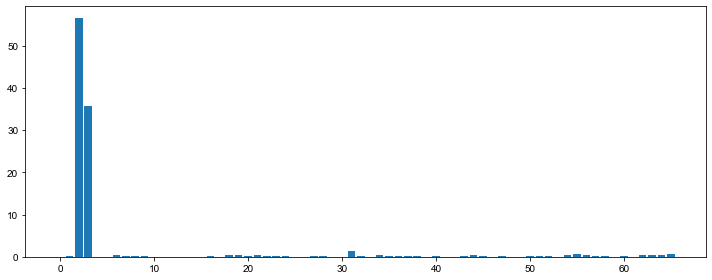

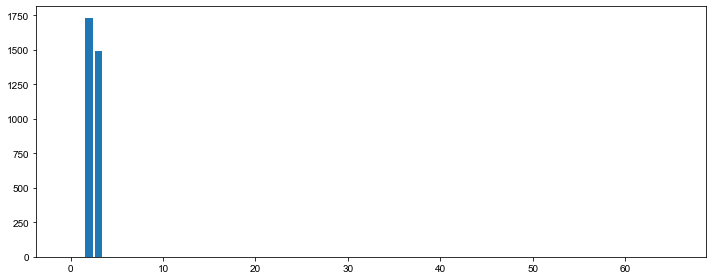

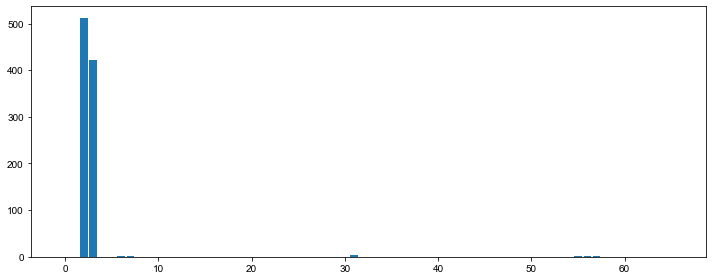

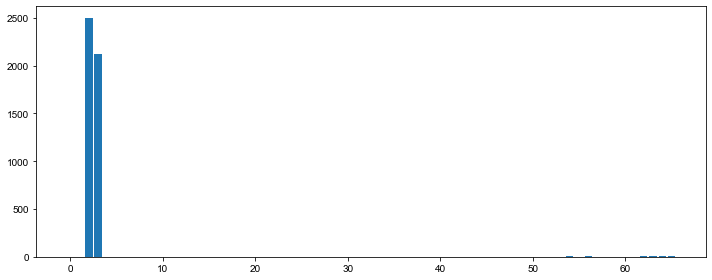

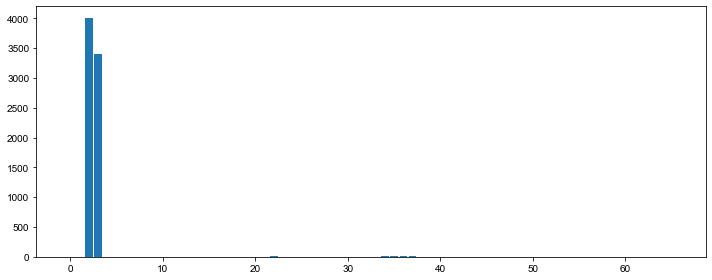

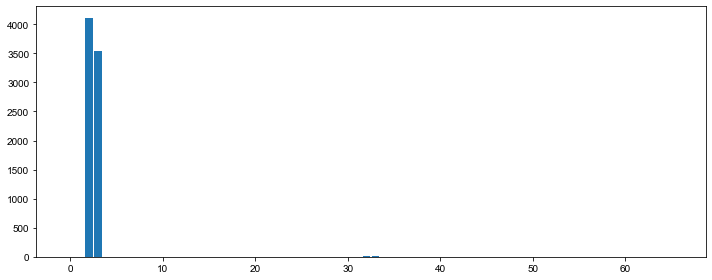

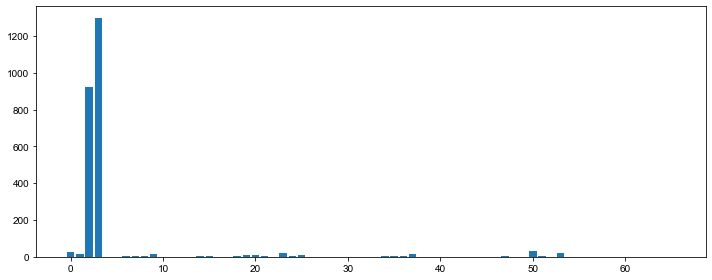

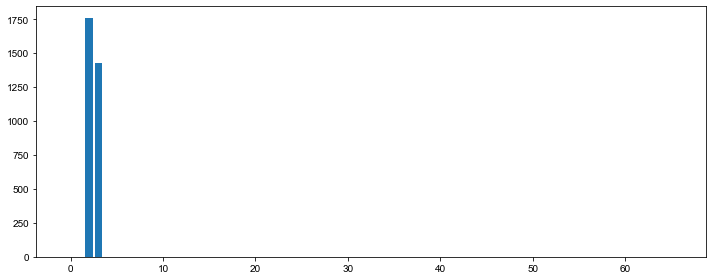

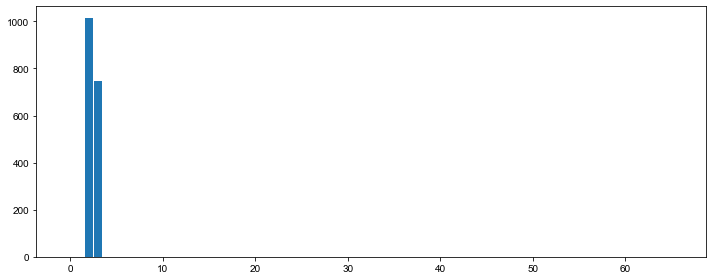

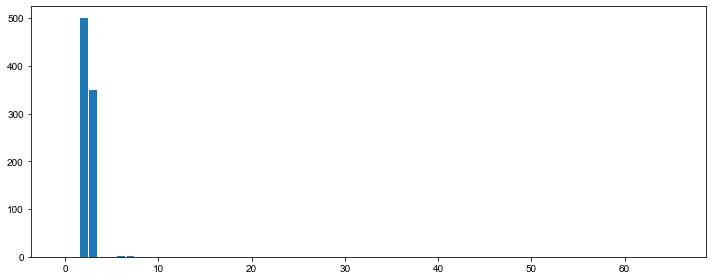

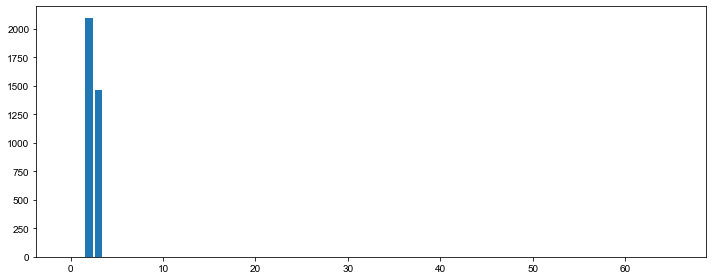

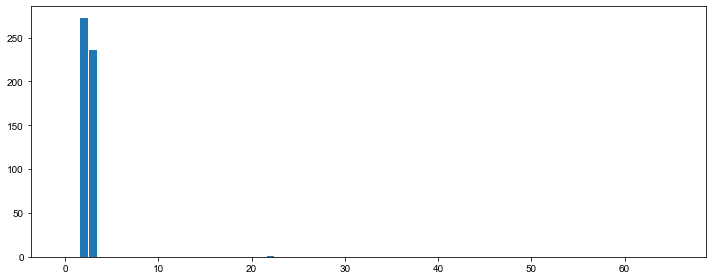

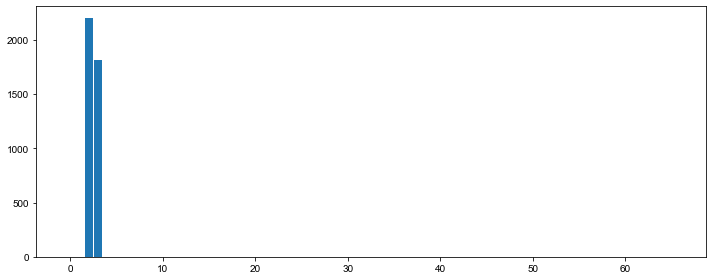

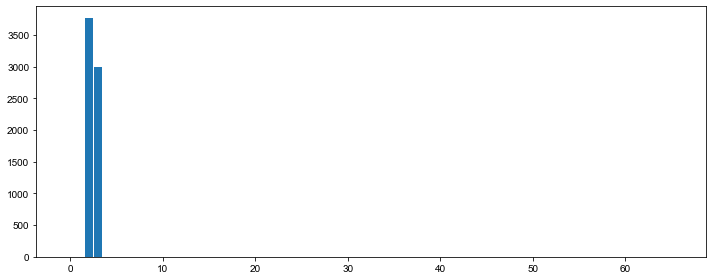

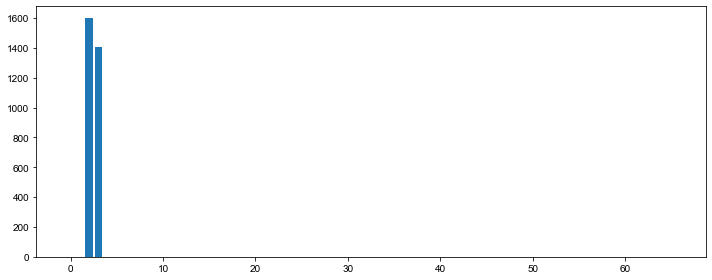

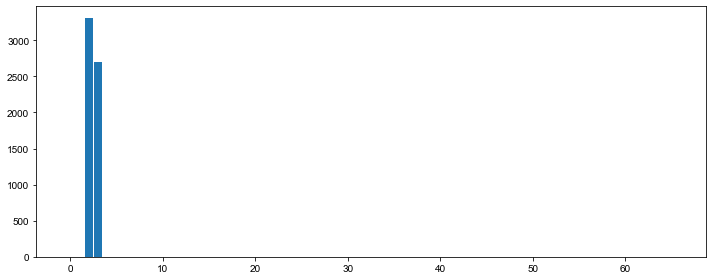

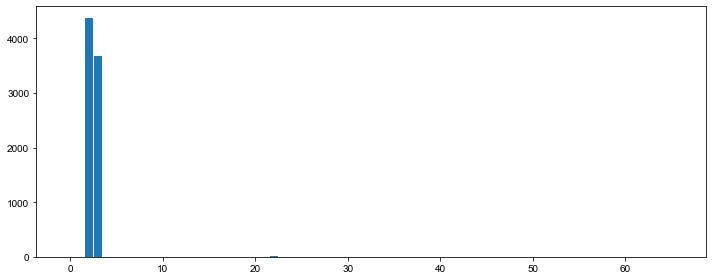

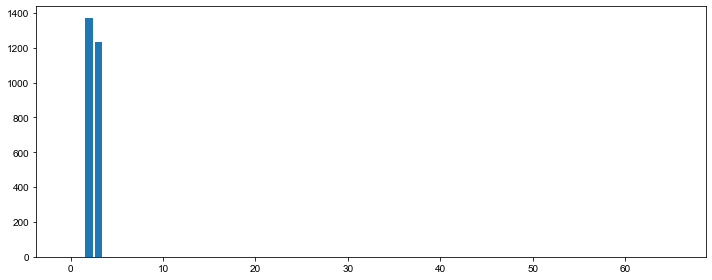

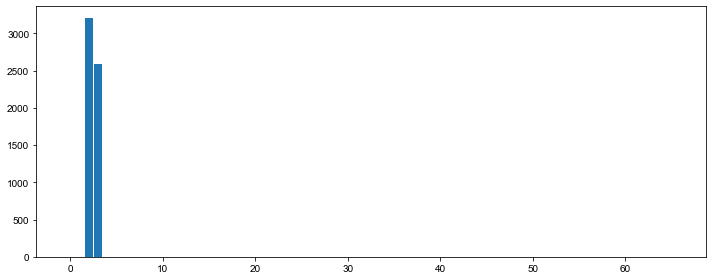

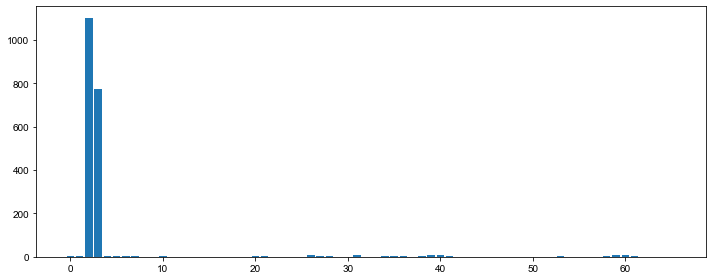

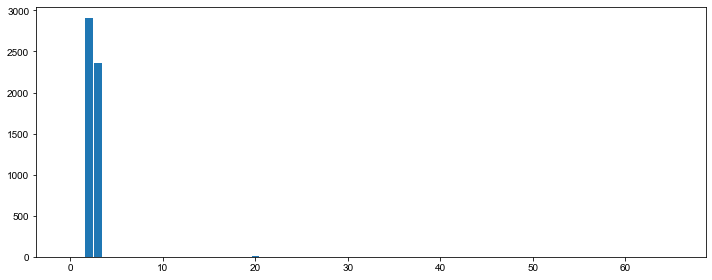

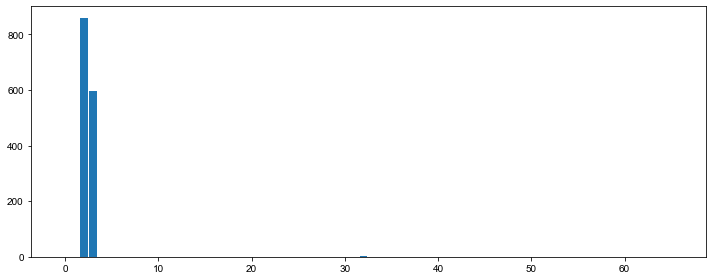

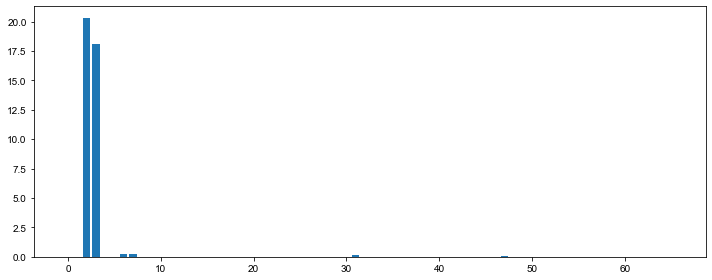

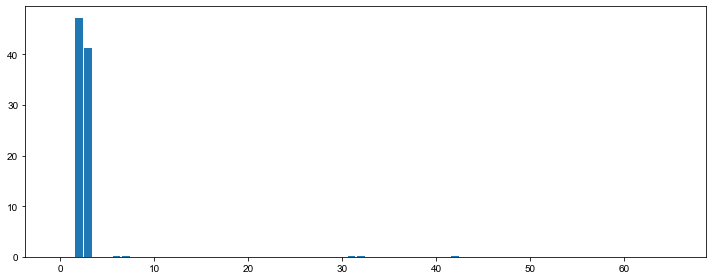

In [128]:
for tid in group2:
    s = dat1.loc[tid]
    xticks = s.index
    ys = s.values
    xs = np.arange(len(ys))
    plt.figure(figsize=(10, 4))
    plt.bar(xs, ys)
    plt.tight_layout()
    plt.show()
    plt.close()
    

In [129]:
anno = pd.read_csv("data/genome/annotation.tsv", sep="\t", index_col=0)

In [148]:
products = dict()
with open("data/genome/annotation.gtf") as f:
    for line in f:
        cols = line.strip("\n").split("\t")
        attris = dict()
        for item in cols[-1].split(";"):
            item = item.strip()
            if item == "":
                continue
            i = item.find(" ")
            key = item[:i]
            val = item[i + 1:].strip("\"").replace("%2C", ",")
            
            attris[key] = val
        if "product" in attris.keys():
            products[attris["transcript_id"]] = attris["product"]           

In [152]:
d1 = anno.loc[group1]
d1["Expression"] = "Common"
d2 = anno.loc[group2]
d2["Expression"] = "Juvenile"
d3 = anno.loc[group3]
d3["Expression"] = "Adult"
d4 = pd.concat([d1, d2, d3], axis=0)
d4["Product"] = [products[tid] for tid in d4.index]
d4 = pd.concat([d4, dat1.loc[d4.index][cols1]], axis=1)
d4.to_csv("Eye.genes1.tsv", sep="\t")

In [147]:
dat1.loc[d4.index][cols1].to_csv("expr.tsv", sep="\t")

In [21]:
cmds = []
for i in range(0, 39):
    url = "https://ftp.ncbi.nlm.nih.gov/blast/db/nr.%02d.tar.gz" % i
    cmd = "wget %s" % url
    cmds.append(cmd)
    url = "https://ftp.ncbi.nlm.nih.gov/blast/db/nr.%02d.tar.gz.md5" % i
    cmd = "wget %s" % url
    cmds.append(cmd)
    # print(url)

In [22]:
with open("data/protein/download.sh", "w+") as fw:
    for cmd in cmds:
        fw.write("%s\n" % cmd)

# Comparision

In [51]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib_venn import *
from pyBioInfo.IO.File import BedFile, FastaFile
rcParams["font.family"] = "arial"

In [10]:
anno = pd.read_csv("data/genome/annotation.tsv", sep="\t")
anno

,TranscriptID,GeneID,GeneName,BioType,Chrom,Start,End,Strand,Length,Longest
0,rna-NC_016870.1:1..68,rna-NC_016870.1:1..68,NaN,NaN,NC_016870.1,0,68,+,68,True
1,rna-NC_016870.1:69..1018,rna-NC_016870.1:69..1018,NaN,NaN,NC_016870.1,68,1018,+,950,True
2,rna-NC_016870.1:1019..1090,rna-NC_016870.1:1019..1090,NaN,NaN,NC_016870.1,1018,1090,+,72,True
3,rna-NC_016870.1:1091..2808,rna-NC_016870.1:1091..2808,NaN,NaN,NC_016870.1,1090,2808,+,1718,True
4,rna-NC_016870.1:2809..2883,rna-NC_016870.1:2809..2883,NaN,NaN,NC_016870.1,2808,2883,+,75,True
...,...,...,...,...,...,...,...,...,...,...
35302,rna-XM_022770253.1,gene-LOC111240302,LOC111240302,protein_coding,NW_019208302.1,145,755,+,431,True
35303,rna-XM_022770254.1,gene-LOC111240303,LOC111240303,protein_coding,NW_019208598.1,5,795,+,462,True
35304,rna-XM_022770257.1,gene-LOC111240307,LOC111240307,protein_coding,NW_019208657.1,763,3157,-,2394,True
35305,rna-XM_022770255.1,gene-LOC111240304,LOC111240304,protein_coding,NW_019208657.1,3661,6269,-,2608,True


In [15]:
counter = Counter(anno["BioType"])
for key in counter.keys():
    value = counter[key]
    if not isinstance(key, str) and np.isnan(key):
        key = "unknown"
    print(key, value)

unknown 24
protein_coding 33024
lncRNA 745
tRNA 1137
pseudogene 299
V_segment 70
C_region 8


In [7]:
tmp = anno[(anno["BioType"] == "protein_coding") & (anno["Longest"])]
seqs = []
with FastaFile("data/genome/genome.fasta") as fasta:
    for chrom, start, end, strand in tmp[["Chrom", "Start", "End", "Strand"]].values:
        if strand == "+":
            v1 = end - 50
            v2 = end + 50
        else:
            v1 = start - 50
            v2 = start + 50
        if v1 < 0:
            continue
        seq = fasta.fetch(chrom=chrom, start=v1, end=v2, strand=strand).upper().replace("T", "U")
        seqs.append(seq)

In [12]:
matrix = np.zeros((4, 100), dtype=np.int)
bases = ["A", "C", "G", "U"]
for seq in seqs:
    for i, base in enumerate(seq):
        if base in bases:
            matrix[bases.index(base)][i] += 1
m = matrix / matrix.sum(axis=0)

In [37]:
xs = np.arange(-50, 50)
plt.figure(figsize=(6, 3))
colors = ["red", "lightskyblue", "green", "purple"]
for i in range(4):
    plt.plot(xs, m[i], lw=3, label=bases[i], color=colors[i])
plt.axvline(-20, ls="--", lw=1, color="grey")
plt.xlim(-50, 50)
plt.xlabel("Distance to poly(A)")
plt.ylim(0, 1)
plt.ylabel("Nucleotide proportion")
plt.legend()
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/polyA.nucleotide.png", dpi=300)
plt.close()

In [ ]:
# merged

In [1]:
records = []
with open("results/stringtie/merged/merged.gtf") as f:
    for line in f:
        line = line.strip("\n")
        if line == "":
            continue
        if line.startswith("#"):
            continue
        record = line.split("\t")
        attris = dict()
        for item in record[-1].split(";"):
            item = item.strip()
            if item == "":
                continue
            i = item.find(" ")
            assert i != -1
            k = item[:i]
            v = item[i + 1:].strip("\"")
            attris[k] = v
        record[-1] = attris
        records.append(record)

In [5]:
header1 = ["chrom", "source", "feature", "start", "end", "score", "strand", "frame"]
header2 = []
for record in records:
    for key in record[-1].keys():
        header2.append(key)
header2 = list(sorted(set(header2)))
header = header1 + header2

In [6]:
rows = []
for record in records:
    row = record[:-1]
    for key in header2:
        row.append(record[-1].get(key, ""))
    rows.append(row)

In [16]:
dat = pd.DataFrame(rows, columns=header)
dat

,chrom,source,feature,start,end,score,strand,frame,exon_number,gene_id,gene_name,ref_gene_id,transcript_id
0,NC_016870.1,StringTie,transcript,1,68,1000,+,.,,merge.1,,,rna-NC_016870.1:1..68
1,NC_016870.1,StringTie,exon,1,68,1000,+,.,1,merge.1,,,rna-NC_016870.1:1..68
2,NC_016870.1,StringTie,transcript,69,1018,1000,+,.,,merge.2,,,rna-NC_016870.1:69..1018
3,NC_016870.1,StringTie,exon,69,1018,1000,+,.,1,merge.2,,,rna-NC_016870.1:69..1018
4,NC_016870.1,StringTie,transcript,1019,1090,1000,+,.,,merge.3,,,rna-NC_016870.1:1019..1090
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729861,NW_019207894.1,Gnomon,exon,8903,8974,.,+,.,16,gene-LOC111240300,LOC111240300,,rna-XM_022770251.1
1729862,NW_019207894.1,Gnomon,exon,9061,9134,.,+,.,17,gene-LOC111240300,LOC111240300,,rna-XM_022770251.1
1729863,NW_019207894.1,Gnomon,exon,9321,9449,.,+,.,18,gene-LOC111240300,LOC111240300,,rna-XM_022770251.1
1729864,NW_019207894.1,Gnomon,exon,9528,9615,.,+,.,19,gene-LOC111240300,LOC111240300,,rna-XM_022770251.1


In [20]:
print(len(dat))

1729866


In [21]:
print(len(set(dat["gene_id"])))

28685


In [28]:
dat1 = dat[dat["feature"] == "transcript"]
print(len(dat1))

125649


In [33]:
dat2 = dat1[dat1["ref_gene_id"] != ""]
print(len(dat2))

32138


In [36]:
gids1 = set(anno["GeneID"])
print(len(gids1))

24214


In [38]:
gids2 = set(dat2["ref_gene_id"])
print(len(gids2))

23871


In [39]:
gids3 = set(dat2["gene_id"])
print(len(gids3))

21232


In [40]:
len(set(dat1["gene_id"]))

28685

In [58]:
plt.figure(figsize=(3, 3))
ret = venn2([343, 7453, 22552], set_labels=["", ""])
ret.get_label_by_id('10').set_text("")
ret.get_label_by_id('01').set_text("")
ret.get_label_by_id('11').set_text("")
# c = venn2_circles(subsets=(343, 7453, 22552), linestyle='dashed')

plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/venn2.1.png", dpi=300)
plt.close()

In [79]:
tids1 = set(anno["TranscriptID"])
len(tids1)

35307

In [81]:
tids2 = set(dat1["transcript_id"])
len(tids2)

125649

In [82]:
tids3 = tids2 & tids1
len(tids3)

35240

In [83]:
plt.figure(figsize=(3, 3))
ret = venn2([67, 90409, 35240], set_labels=["", ""])
ret.get_label_by_id('10').set_text("")
ret.get_label_by_id('01').set_text("")
ret.get_label_by_id('11').set_text("")
# c = venn2_circles(subsets=(343, 7453, 22552), linestyle='dashed')

plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/venn2.2.png", dpi=300)
plt.close()

In [100]:
counter1 = Counter(Counter(anno[[gid in gids2 for gid in anno["GeneID"]]]["GeneID"]).values())
counter2 = Counter(Counter(dat1[[gid in gids3 for gid in dat1["gene_id"]]]["gene_id"]).values())

In [101]:
ys1 = np.zeros(10, dtype=np.int)
ys2 = np.zeros(10, dtype=np.int)
xs = np.arange(0, 10)

for i in range(0, 9):
    ys1[i] = counter1[i + 1]
    ys2[i] = counter2[i + 1]
ys1[-1] = sum(counter1.values()) - sum(ys1)
ys2[-1] = sum(counter2.values()) - sum(ys2)

In [112]:
plt.figure(figsize=(5, 3))
plt.bar(xs - 0.2, ys1, width=0.4, label="NCBI")
plt.bar(xs + 0.2, ys2, width=0.4, label="Intergrated")
plt.xlabel("Number of isoform per gene")
plt.xticks(xs, ["1", "2", "3", "4", "5", "6", "7", "8", "9", ">=10"])
plt.ylim(0, 20000)
plt.ylabel("Gene number")
plt.yticks([0, 5000, 10000, 15000, 20000])
plt.legend()
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/bar.2.png", dpi=300)
plt.close()

In [52]:
pairs = []
for record in records:
    if record[2] == "transcript":
        tid = record[-1]["transcript_id"]
        if "gene_id" in record[-1].keys():
            gid = record[-1]["gene_id"]
        else:
            gid = tid
        pairs.append([gid, tid])

In [56]:
dat = pd.DataFrame(pairs)
dat.columns = ["GID", "TranscriptID"]
dat

,GID,TranscriptID
0,merge.1,rna-NC_016870.1:1..68
1,merge.2,rna-NC_016870.1:69..1018
2,merge.3,rna-NC_016870.1:1019..1090
3,merge.4,rna-NC_016870.1:1091..2808
4,merge.5,merge.5.1
...,...,...
125644,gene-LOC111240295,rna-XM_022770246.1
125645,gene-LOC111240298,rna-XR_002665933.1
125646,gene-LOC111240299,rna-XM_022770249.1
125647,gene-LOC111240300,rna-XM_022770250.1


In [59]:
merge = dat.merge(anno, left_on="TranscriptID", right_on="TranscriptID", how="outer")

In [64]:
vs1 = merge["GID"].isna()
vs2 = merge["GeneID"].isna()

In [69]:
d1 = merge[(merge["GID"].isna()) & (~merge["GeneID"].isna())] # NCBI only
d2 = merge[(~merge["GID"].isna()) & (merge["GeneID"].isna())] # StringTie only
n1 = len(d1)
n2 = len(d2)
n3 = len(merge) - n1 - n2
print(n1, n2, n3)

67 90409 35240


In [75]:
plt.figure(figsize=(3, 3))
ret = venn2([n1,n2,n3], set_labels=["", ""])
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/venn2.png", dpi=300)
plt.close()

In [85]:
counter1 = Counter(Counter(merge[~merge["GeneID"].isna()]["GeneID"]).values())
counter2 = Counter(Counter(merge[~merge["GID"].isna()]["GID"]).values())

In [89]:
ys1 = np.zeros(10, dtype=np.int)
ys2 = np.zeros(10, dtype=np.int)
xs = np.arange(0, 10)

for i in range(0, 9):
    ys1[i] = counter1[i + 1]
    ys2[i] = counter2[i + 1]
ys1[-1] = sum(counter1.values()) - sum(ys1)
ys2[-1] = sum(counter2.values()) - sum(ys2)

In [60]:
flags = []
with open("results/stringtie/merged/compare.tracking") as f:
    for line in f:
        values = line.strip("\n").split("\t")
        flags.append(values[3])
counter = Counter(flags)
counter

Counter({'=': 35106,
         'k': 14708,
         'o': 1047,
         'j': 49796,
         'n': 5356,
         'i': 1676,
         'm': 5834,
         'u': 9013,
         'x': 2478,
         'p': 183,
         'y': 434,
         's': 17,
         'c': 1})

In [66]:
xticks = []
counts = []
for key, value in sorted(counter.items(), key=lambda item: item[1], reverse=True):
    print(key, value)
    xticks.append(key)
    counts.append(value)

j 49796
= 35106
k 14708
u 9013
m 5834
n 5356
x 2478
i 1676
o 1047
y 434
p 183
s 17
c 1


In [77]:
xs = np.arange(len(counts))
plt.figure(figsize=(4, 3))
plt.bar(xs, counts, color="dodgerblue", lw=1, edgecolor="black")
plt.xticks(xs, xticks)
plt.ylim(0, 60000)
plt.ylabel("Transcript count")
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/bar.1.png", dpi=300)
plt.close()

In [113]:
from Bio import SeqIO

In [117]:
with open("genome.hdrs", 'w+') as fw:
    for record in SeqIO.parse("data/genome/genome.fasta", "fasta"):
        name = record.name
        length = len(record)
        n = record.seq.upper().count("N")
        length1 = length - n
        s = ">%s /len=%d /nonNlen=%d /org=GTS" % (name, length, length1)
        fw.write(s + "\n")

In [1]:
from pyBioInfo.IO.File import GtfFile, GtfGeneBuilder

In [3]:
with GtfFile("data/genome/annotation.gtf") as f:
    records1 = [x for x in f]

In [9]:
with GtfFile("results/stringtie/merged/merged.gtf") as f:
    records1 = [x for x in f]

In [10]:
genes = list(GtfGeneBuilder(records1))

In [11]:
len(genes)

25332

In [12]:
sum([len(g.transcripts) for g in genes])

48851

In [8]:
gids = set()
for record in records1:
    gids.add(record.attributes["gene_id"])
len(gids)

24214

In [15]:
gids = set()
for record in records1:
    if "ref_gene_id" in record.attributes:
        gids.add(record.attributes["ref_gene_id"])
print(len(gids))

24214


In [3]:
from pyBioInfo.IO.File import GtfFile, GtfTranscriptBuilder

In [4]:
path = "results/stringtie/taco/assembly.sorted.gtf.gz"
with GtfFile(path) as f:
    transcripts = [t for t in GtfTranscriptBuilder(f)]

In [7]:
for t in sorted(transcripts):
    transcript_record = t.records["transcript"][0]
    gene_id = transcript_record.attributes["gene_id"]
    transcript_id = transcript_record.attributes["transcript_id"]
    name = "%s;%s" % (gene_id, transcript_id)
    print(name)
    break
    

G6;TU6


In [8]:
len(transcripts)

107399